<a href="https://colab.research.google.com/github/bisht-prachi/Interface-growth-driven-by-a-single-active-particle/blob/main/Ocean_flow_around_Philippines_Archipelago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ocean Flow Dataset Context

This project analyzes ocean current flows in the Philippine Archipelago, a region with complex geometry and interconnected seas. The dataset (`u.csv` and `v.csv`) contains 2D ocean flow vectors, averaged from the surface to a depth of 400 m or the seafloor, over 100 time steps (3-hour intervals starting from 0 hrs, January 2009). The `u` files store horizontal flow components, and `v` files store vertical components, both in km/h. `mask.csv` provides a land-water mask (1 = water, 0 = land). Grid spacing is 3 km, with coordinates referenced from the bottom-left corner.

Data courtesy: [MSEAS Group, MIT](http://mseas.mit.edu/)

In [ ]:
import numpy as np
import pandas as pd
import glob

# Part I - Ocean Flow

## Retrieve data

In [ ]:
from pathlib import Path
data_dir = Path('/OceanFlow/')

In [ ]:
# Gather file paths
u_files = sorted(glob.glob("OceanFlow/*u.csv"), key=lambda x: int(Path(x).stem.split('u')[0]))
v_files = sorted(glob.glob("OceanFlow/*v.csv"), key=lambda x: int(Path(x).stem.split('v')[0]))

print(f"Found {len(u_files)} u-files.")

# Preallocate lists to store all u and v data
u_stack = []
v_stack = []

for u_file, v_file in zip(u_files, v_files):
    u = pd.read_csv(u_file, header=None).to_numpy()
    v = pd.read_csv(v_file, header=None).to_numpy()
    u_stack.append(u)
    v_stack.append(v)

# Convert to 3D numpy arrays: shape (time, y, x)
u_stack = np.array(u_stack)
v_stack = np.array(v_stack)


Found 100 u-files.


In [ ]:
# Save to .npy files
u_path = "OceanFlow/u_stack.npy"
v_path = "OceanFlow/v_stack.npy"

np.save(u_path, u_stack)
np.save(v_path, v_stack)

u_path, v_path

('OceanFlow/u_stack.npy', 'OceanFlow/v_stack.npy')

## Computing mean velocity in both directions

In [ ]:
# Compute overall average of u and v
avg_u = np.mean(u_stack)
avg_v = np.mean(v_stack)

print(f"Average velocity vector: u = {avg_u:.3f} km/h, v = {avg_v:.3f} km/h")


Average velocity vector: u = -0.094 km/h, v = -0.035 km/h


## Computing speed for all the grid points at all the time stamps

In [ ]:
speed_stack = np.sqrt(u_stack**2 + v_stack**2)  # shape: (time, y, x)

In [ ]:
np.stack(speed_stack, axis=0).shape

(100, 504, 555)

## Locating coordinates (in km) of the point with smallest variation in speed flow

In [ ]:
speed_stack = np.stack(speed_stack, axis=0)  # shape: (time, y, x)
speed_variance = np.var(speed_stack, axis=0)

# Mask out all zero variance
nonzero_mask = speed_variance > 0
valid_variance = np.where(nonzero_mask, speed_variance, np.inf)

# Find minimum
min_index = np.unravel_index(np.argmin(valid_variance), valid_variance.shape)
y_idx, x_idx = min_index
x_km = x_idx * 3
y_km = y_idx * 3

print(f"Minimum variance at x = {x_km} km, y = {y_km} km")


Minimum variance at x = 510 km, y = 363 km


## Locating coordinates (in km) and the time stamp (in hours) of the point where the flow has its maximum horizontal velocity

In [ ]:
max_u = -np.inf
max_time = 0
max_x = 0
max_y = 0

for t, u_file in enumerate(u_files):
    u = pd.read_csv(u_file, header=None).to_numpy()
    local_max = np.max(u)
    if local_max > max_u:
        max_u = local_max
        y_idx, x_idx = np.unravel_index(np.argmax(u), u.shape)
        max_time = t
        max_x = x_idx
        max_y = y_idx

print(f"Max u = {max_u} at time = {max_time*3} hrs, x = {max_x*3} km, y = {max_y*3} km")


Max u = 5.7993 at time = 84 hrs, x = 1041 km, y = 543 km


##  Identify ocations in the Philippine Archipelago with long-range correlations.

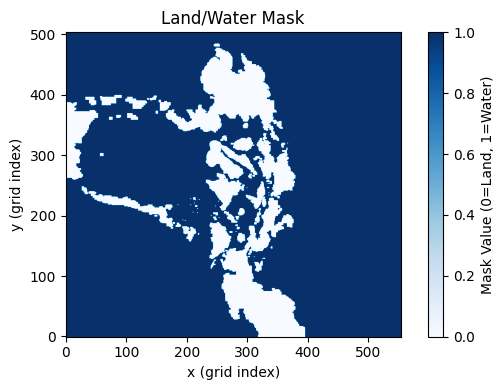

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the mask (0 = land, 1 = water)
mask = pd.read_csv("OceanFlow/mask.csv", header=None).to_numpy()

# Plot
plt.figure(figsize=(6,4))
plt.imshow(mask, cmap="Blues", origin='lower')  # origin='lower' to match (0,0) at bottom-left
plt.title("Land/Water Mask")
plt.xlabel("x (grid index)")
plt.ylabel("y (grid index)")
plt.colorbar(label="Mask Value (0=Land, 1=Water)")
plt.grid(False)
plt.tight_layout()
plt.show()


Among the 555x504 points 10^5 random pairs were sampled for correlation between horizontal velocity
components. The figure only shows pairs which were at least 30 grid points apart and for which absolute
correlation was greater than 0.95. Similar exercise was conducted for correlation between vertical
velocity components. It is interesting to note that the strongest connections are across the map along the
southwest-northeast axis in the current layout; the horizontal components are strongly anti-correlated and
the vertical components are strongly related. It is likely that vortices of opposite polarity are formed in the
SW, NE zones. There is a strong possibility that the observations were recorded during the Monsoon
months (Southwest Monsoon: June-September possibly) during which the Habagat winds blow across
the SW-NE axis driving the ocean current flow  [Fishing in a vortex](https://msi.upd.edu.ph/fishing-in-a-vortex/).

C:\Users\bisht\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\bisht\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


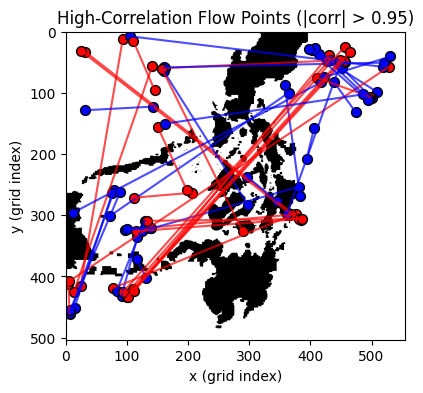

In [ ]:
import random

time_len, ny, nx = u_stack.shape
n_points = ny * nx

# Step 2: Reshape to (time, n_points)
u_reshaped = u_stack.reshape(time_len, n_points)
v_reshaped = v_stack.reshape(time_len, n_points)

# Step 3: Sample point pairs
num_samples = 10**5
high_corr_pairs = []

for _ in range(num_samples):
    i = random.randint(0, n_points - 1)
    j = random.randint(0, n_points - 1)
    if i == j:
        continue

    # Coordinates
    y1, x1 = divmod(i, nx)
    y2, x2 = divmod(j, nx)

    # Filter distant points (at least ~30 grid apart)
    if np.sqrt((x1 - x2)**2 + (y1 - y2)**2) < 30:
        continue

    # Correlations
    corr_u = np.corrcoef(u_reshaped[:, i], u_reshaped[:, j])[0, 1]
    corr_v = np.corrcoef(v_reshaped[:, i], v_reshaped[:, j])[0, 1]
    avg_corr = corr_u#(corr_u + corr_v) / 2

    if abs(avg_corr) > 0.95:
        high_corr_pairs.append(((x1, y1), (x2, y2), avg_corr))

# Step 4: Visualize
# Load map mask
mask = pd.read_csv("OceanFlow/mask.csv", header=None).to_numpy()

# Plot map
plt.figure(figsize=(6,4))
plt.imshow(mask, cmap='Greys_r', origin='upper')
plt.title("High-Correlation Flow Points (|corr| > 0.95)")

# Draw lines and points
for (x1, y1), (x2, y2), corr in high_corr_pairs:
    color = 'blue' if corr > 0 else 'red'
    plt.plot([x1, x2], [y1, y2], color=color, linewidth=1.5, alpha=0.7)
    plt.scatter([x1, x2], [y1, y2], c=color, s=50, edgecolors='black')

plt.xlabel("x (grid index)")
plt.ylabel("y (grid index)")
plt.grid(False)
plt.show()

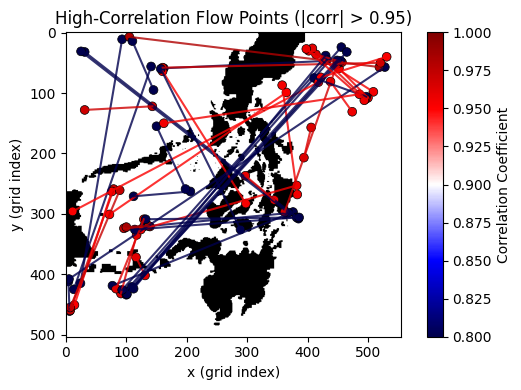

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# Normalize correlation values from -1 to 1 for colormap
all_corrs = [corr for _, _, corr in high_corr_pairs]
norm = colors.Normalize(vmin=0.8, vmax=1)
cmap = cm.seismic  # Good diverging colormap for -1 to 1

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(mask, cmap='Greys_r', origin='upper')
ax.set_title("High-Correlation Flow Points (|corr| > 0.95)")

# Draw lines with colors based on correlation value
for (x1, y1), (x2, y2), corr in high_corr_pairs:
    color = cmap(norm(corr))
    ax.plot([x1, x2], [y1, y2], color=color, linewidth=1.5, alpha=0.8)
    ax.scatter([x1, x2], [y1, y2], c=[color, color], s=40, edgecolors='black', linewidths=0.5)

# Colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label("Correlation Coefficient")

ax.set_xlabel("x (grid index)")
ax.set_ylabel("y (grid index)")
ax.grid(False)
plt.tight_layout()
plt.show()


## Particle Simulation in Ocean Flow Field

A collection of 100 particles, initially distributed uniformly across the grid, were simulated over time as they evolved with the ocean flow field.

At any given time, the position of a particle located at $(x(t), y(t))$ is updated according to the rule:

$
x(t + \Delta t) = x(t) + \Delta t \cdot u(t)
$ \\
$
y(t + \Delta t) = y(t) + \Delta t \cdot v(t)
$

where $[u(t), v(t)]$ is the velocity vector from the flow field at time $t$ and the particle’s location, and $\Delta t = 3$ hours is the time step.

To obtain the velocity at a particle's location, the position is rounded to the nearest integer and used to index into the velocity field.

The simulation was performed over a total duration of 300 hours (i.e., 100 time steps). If a particle encountered land (as defined by the `mask.csv`, where 0 = land), its simulation was terminated.

Figure 2 below shows a snapshot of the particle positions at various time instances during the simulation.



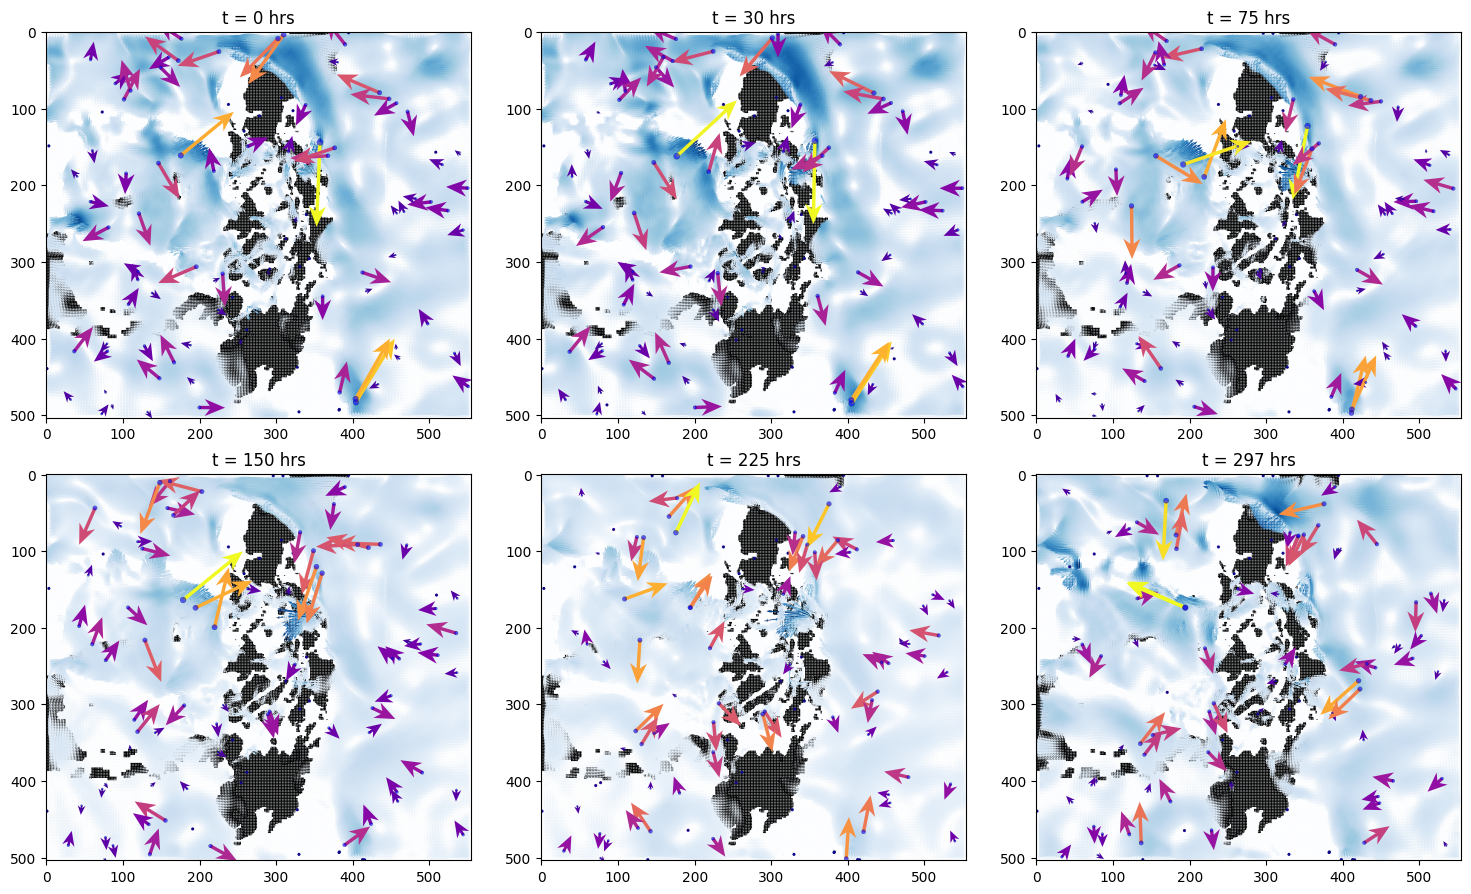

In [ ]:
num_particles = 100
height, width = u_stack.shape[1], u_stack.shape[2]

# (x, y) positions in km
positions = np.random.rand(num_particles, 2)
positions[:, 0] *= width
positions[:, 1] *= height


def update_positions(positions, u_stack, v_stack, mask, t, dt=1.0):
    new_positions = positions.copy()
    for i, (x, y) in enumerate(positions):
        xi = int(np.clip(round(x), 0, u_stack.shape[2]-1))
        yi = int(np.clip(round(y), 0, u_stack.shape[1]-1))

        # Check if the particle is on land
        if mask[yi, xi] == 0:
            continue  # Do not update position
        else:
            u = u_stack[t, yi, xi]
            v = v_stack[t, yi, xi]
            new_positions[i, 0] += u * dt
            new_positions[i, 1] += v * dt
    return new_positions

positions_list = [positions.copy()]  # Store initial positions at t=0
positions_all = [positions.copy()]   # Store positions at all time steps

for t in range(0, 100):
    # Update positions based on flow data (u_stack and v_stack)
    positions = update_positions(positions, u_stack, v_stack,mask, t)

    # Store positions at all time steps
    positions_all.append(positions.copy())

    # Store positions only at specific time steps (e.g., t = 0, 10, 25, 50, 75, 99)
    if t in [0, 10, 25, 50, 75, 99]:
        positions_list.append(positions.copy())

# Now `positions_all` contains positions for all time steps (from t=0 to t=99)
# And `positions_list` contains positions at specific time steps: 0, 10, 25, 50, 75, and 99



## visulaization
times = [0, 10,25, 50,75, 99]
fig, axs = plt.subplots(2,3, figsize=(15, 9))

for ax, t, pos in zip(axs.ravel(), times, positions_list):

    u_t = u_stack[t]
    v_t = v_stack[t]
    flow_magnitudes = []

    quiv_x, quiv_y, quiv_u, quiv_v, quiv_color = [], [], [], [], []

    for (x, y) in pos:
        xi = int(np.clip(round(x), 0, u_t.shape[1] - 1))
        yi = int(np.clip(round(y), 0, u_t.shape[0] - 1))
        u_val = u_t[yi, xi]
        v_val = v_t[yi, xi]
        mag = np.sqrt(u_val**2 + v_val**2)

        flow_magnitudes.append(mag * 10)  # For scatter size

        quiv_x.append(x)
        quiv_y.append(y)
        quiv_u.append(u_val)
        quiv_v.append(v_val)
        quiv_color.append(mag)

    stride = 2  # adjust for density
    X, Y = np.meshgrid(np.arange(0, width, stride), np.arange(0, height, stride))
    U = u_t[::stride, ::stride]
    V = v_t[::stride, ::stride]
    # Compute flow magnitude for quiver color
    flow_mag_quiver = np.sqrt(U**2 + V**2)
    ax.quiver(X, Y, U, V, flow_mag_quiver, cmap='Blues', scale=50, width=0.002)

    ax.quiver(quiv_x, quiv_y, quiv_u, quiv_v, quiv_color,
          cmap='plasma', scale=10, width=0.008, headwidth=5, headlength=6)
    ax.scatter(pos[:, 0], pos[:, 1], s=flow_magnitudes, alpha=0.6,
               c='blue', edgecolors='black', linewidth=0.2)


    ax.imshow(mask, cmap='Greys_r', origin='upper')

    ax.set_title(f"t = {t*3} hrs")
    # ax.set_xlim(0, width)
    # ax.set_ylim(0, height)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()


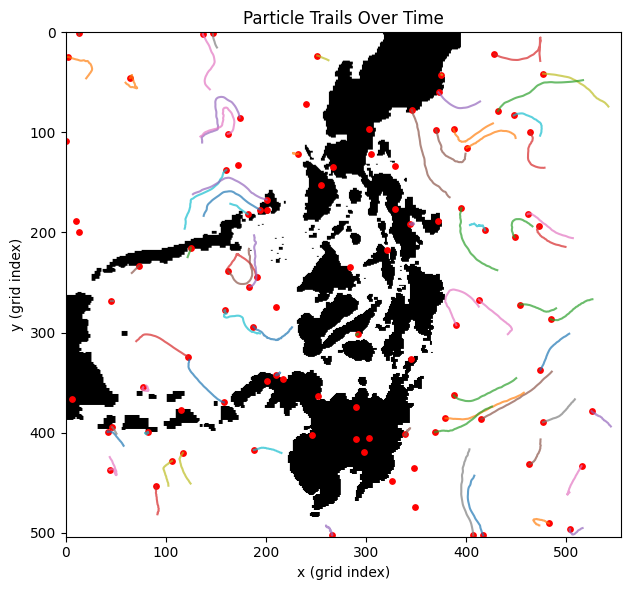

In [ ]:
## visualizing particle trails

num_particles = 100
height, width = u_stack.shape[1], u_stack.shape[2]

# (x, y) positions in km
positions = np.random.rand(num_particles, 2)
positions[:, 0] *= width
positions[:, 1] *= height

def update_positions(positions, u_stack, v_stack, mask, t, dt=1.0):
    new_positions = positions.copy()
    for i, (x, y) in enumerate(positions):
        xi = int(np.clip(round(x), 0, u_stack.shape[2]-1))
        yi = int(np.clip(round(y), 0, u_stack.shape[1]-1))

        # Check if the particle is on land
        if mask[yi, xi] == 0:
            continue  # Do not update position
        else:
            u = u_stack[t, yi, xi]
            v = v_stack[t, yi, xi]
            new_positions[i, 0] += u * dt
            new_positions[i, 1] += v * dt
    return new_positions

# Initialize trails: (num_particles, timesteps + 1, 2)
timesteps = 100
trails = np.zeros((num_particles, timesteps + 1, 2))
trails[:, 0, :] = positions

# Update positions and store trails
for t in range(timesteps):
    positions = update_positions(positions, u_stack, v_stack, mask, t)
    trails[:, t + 1, :] = positions

# Plotting trails
plt.figure(figsize=(10, 6))
plt.imshow(mask, cmap='Greys_r', origin='upper')
plt.title("Particle Trails Over Time")

# Draw trails
for i in range(num_particles):
    trail = trails[i]
    plt.plot(trail[:, 0], trail[:, 1], alpha=0.7, linewidth=1.5)
    plt.scatter(trail[-1, 0], trail[-1, 1], c='red', s=15)  # Mark end point

plt.xlabel("x (grid index)")
plt.ylabel("y (grid index)")
plt.grid(False)
plt.xlim(0, width)
plt.ylim(0, height)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Simulating Search Area Drift via Particle Flow

To simulate the drift of potential crash debris, we initialize 1000 particles distributed around the presumed crash location at coordinates $(300, 1050)$ in the Sulu Sea. The initial particle positions are sampled from a bivariate normal distribution with mean $(300, 1050)$ and four different covariance matrices of the form:

$
\Sigma = \begin{bmatrix} \sigma^2 & 0 \\ 0 & \sigma^2 \end{bmatrix}, \quad \text{with } \sigma^2 \in \{1, 25, 100, 400\}
$

As before, particles evolve with the ocean flow field over time using:

$
x(t + \Delta t) = x(t) + \Delta t \cdot u(t), \quad
y(t + \Delta t) = y(t) + \Delta t \cdot v(t)
$

with $\Delta t = 3$ hours. The simulation runs up to $t = 128$ hours. Particles that touch land (as defined in `mask.csv`) remain stationary thereafter.

### Figure 4

Each row in Figure 4 corresponds to a different initial variance ($\sigma^2$), with snapshots of particle positions at:

- $t = 48$ hours  
- $t = 72$ hours  
- $t = 128$ hours

### Observations

- **Low Uncertainty ($\sigma^2 = 1$)**: Particles stay tightly clustered. At $t = 128$, the mean drifted to $(136, 382)$ with standard deviation $(\sigma_x, \sigma_y) = (5.05, 0.99)$.
  
- **Moderate Uncertainty ($\sigma^2 = 25$)**: Mean location shifts to $(132, 379)$, but the particle cloud splits into two visible clusters—one near Pangutaran and another drifting toward the Philippine mainland.

- **High Uncertainty ($\sigma^2 = 100, 400$)**: A bimodal distribution becomes more evident. Currents transport particles in diverging paths:
  - One cluster heads along the southern islands of the Sulu Sea.
  - The other drifts toward the mainland coast.

Additionally, the spread in the **horizontal direction** is significantly greater than in the vertical.

### Recommendation

- If the search begins **immediately** after the crash, it should focus around the original site.
- If the search is **delayed beyond 100 hours**, efforts should prioritize shorelines along the southern Sulu Sea islands and the coastal regions of the Philippines.

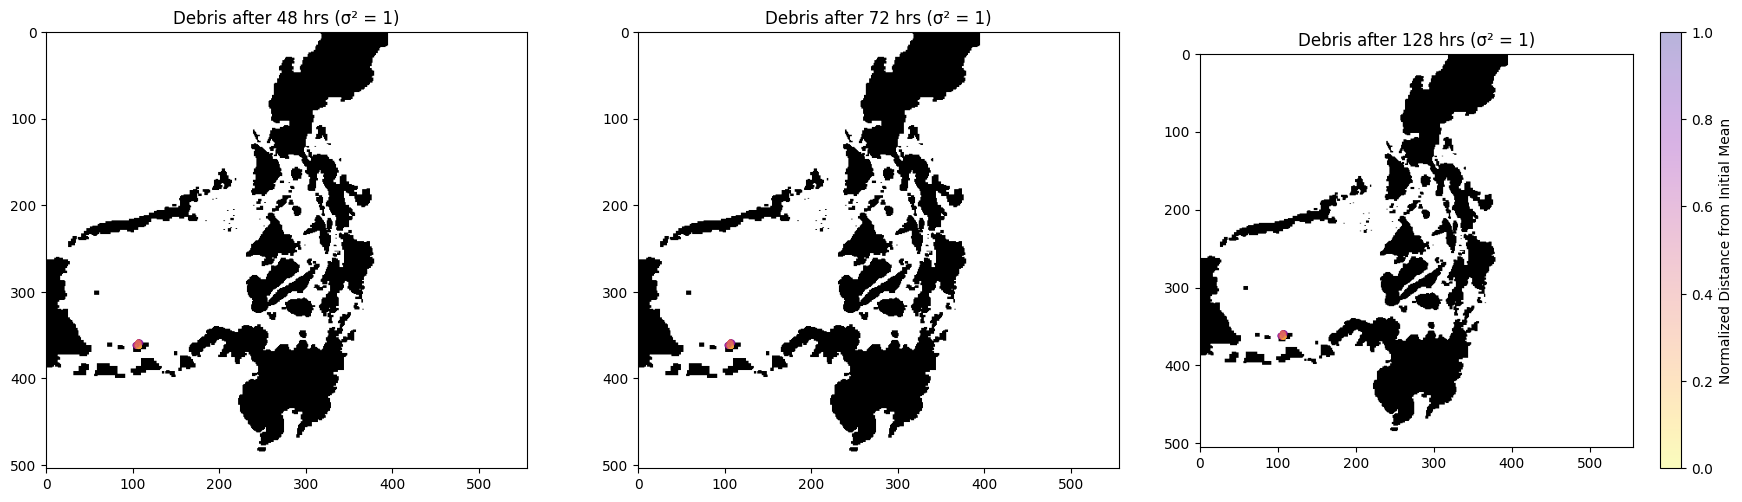

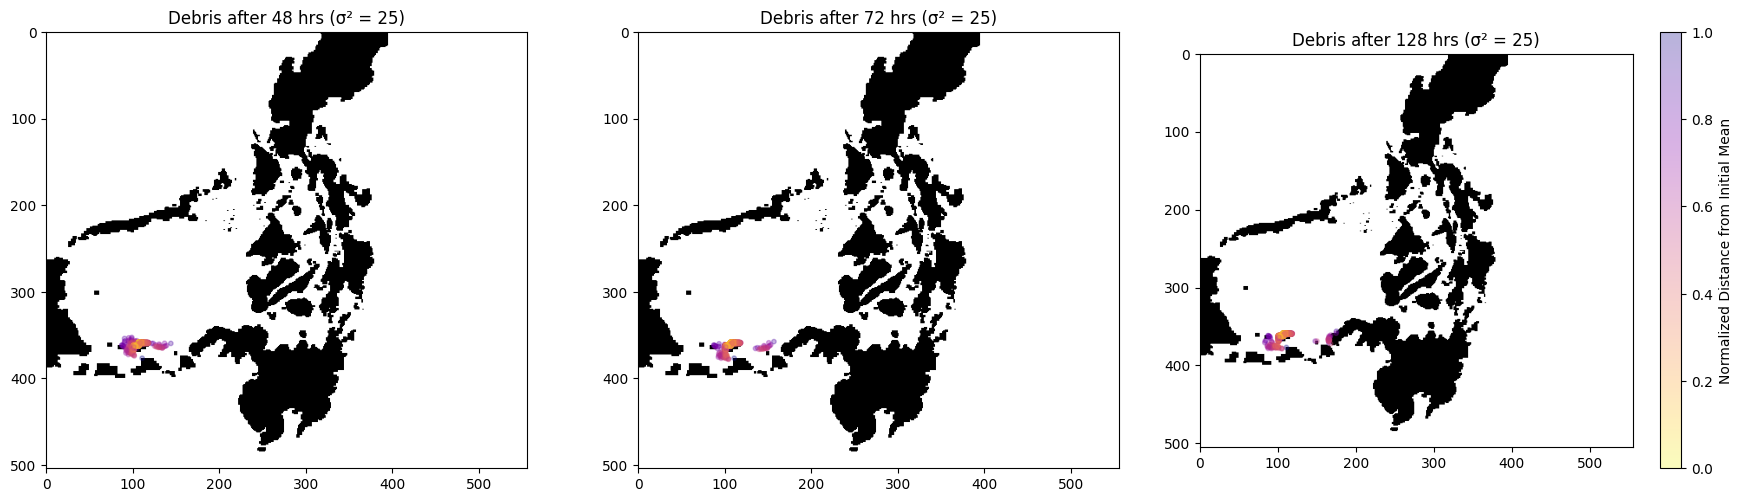

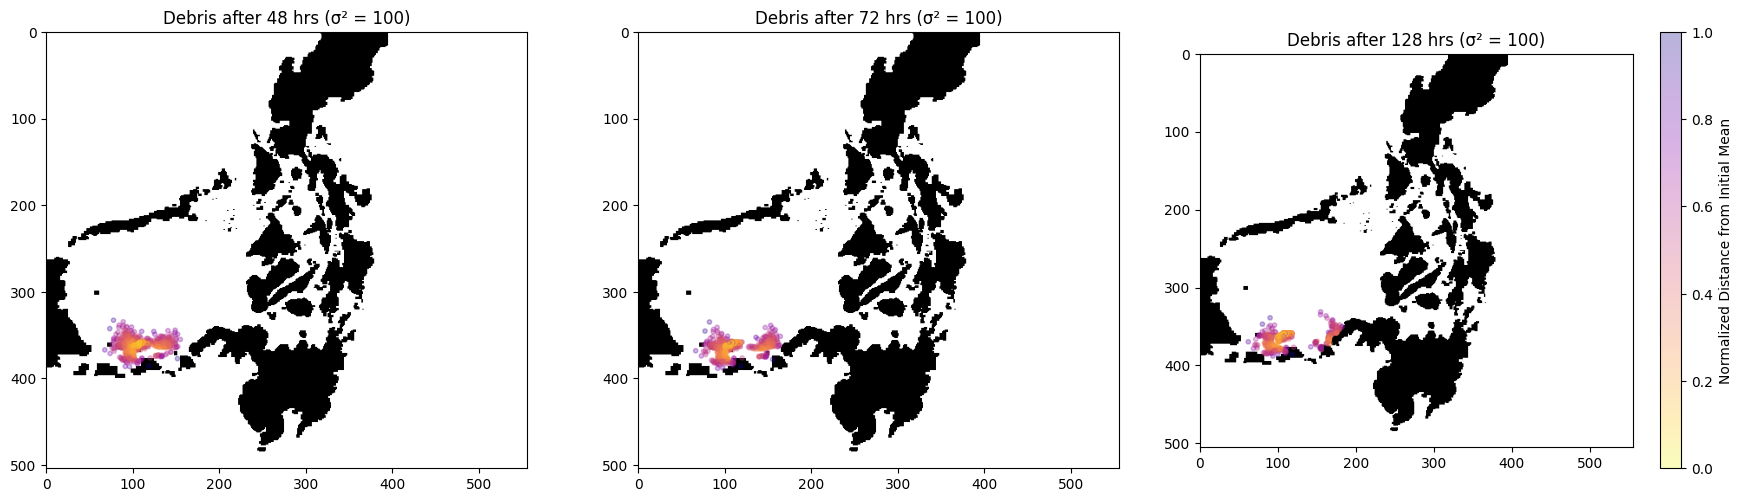

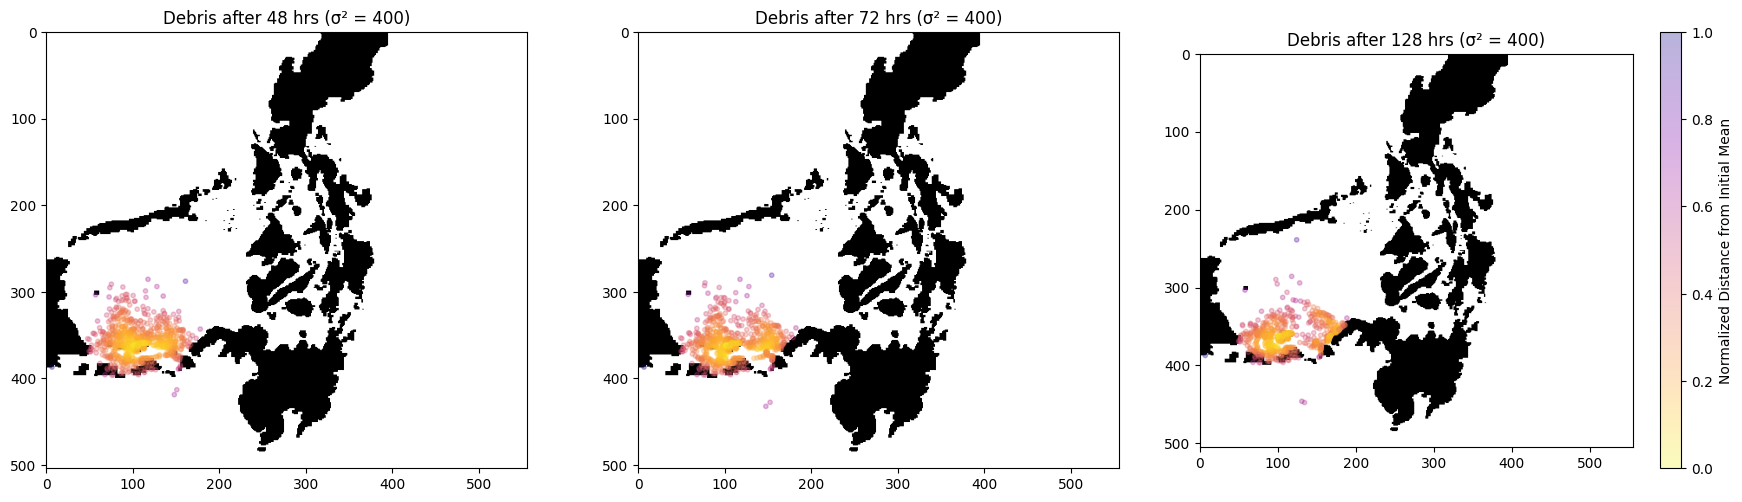

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import map_coordinates

mean = np.array([100, 350])  # x, y in grid units
variances = [1, 25, 100, 400]  # σ²
timesteps = [48, 72, 128]  # in hours
dt = 3
steps = [t // dt for t in timesteps]

num_particles = 1000

for sigma2 in variances:
    sigma = np.sqrt(sigma2)
    particles = np.random.multivariate_normal(mean, np.diag([sigma2, sigma2]), num_particles)
    initial_distances = np.linalg.norm(particles - mean, axis=1)
    normalized_distances = (initial_distances - np.min(initial_distances)) / (np.max(initial_distances) - np.min(initial_distances))
    cmap = plt.cm.plasma_r

    particle_tracks = [particles.copy()]
    active = np.ones(num_particles, dtype=bool)  # Track which particles are still active (on water)

    for t in range(1, max(steps) + 1):
        u = u_stack[t]
        v = v_stack[t]

        current_positions = particle_tracks[-1].copy()

        # Interpolate only for active particles
        x = current_positions[active, 0]
        y = current_positions[active, 1]

        u_interp = map_coordinates(u, [y, x], order=1, mode='nearest')
        v_interp = map_coordinates(v, [y, x], order=1, mode='nearest')

        # Update positions
        current_positions[active, 0] += u_interp * dt
        current_positions[active, 1] += v_interp * dt

        # Convert to int to check land vs. sea
        x_int = np.clip(np.round(current_positions[active, 0]).astype(int), 0, mask.shape[1] - 1)
        y_int = np.clip(np.round(current_positions[active, 1]).astype(int), 0, mask.shape[0] - 1)

        # Check land mask (0 = land)
        still_on_water = (mask[y_int, x_int] != 0)
        active_indices = np.where(active)[0]
        active[active_indices[~still_on_water]] = False  # Deactivate particles that hit land

        particle_tracks.append(current_positions)

    # Plot results
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, step in enumerate(steps[:3]):
        ax = axes[i]
        pos = particle_tracks[step]
        scatter = ax.scatter(pos[:, 0], pos[:, 1], s=10, c=normalized_distances, cmap=cmap, alpha=0.3)
        ax.set_title(f"Debris after {timesteps[i]} hrs (σ² = {sigma2})")
        ax.set_xlim(0, u_stack.shape[2])
        ax.set_ylim(0, u_stack.shape[1])
        ax.invert_yaxis()

        ax.imshow(mask, cmap='Greys_r', origin='lower')
        ax.grid(False)

    fig.colorbar(scatter, ax=axes[-1], label='Normalized Distance from Initial Mean')
    plt.tight_layout()
    plt.show()


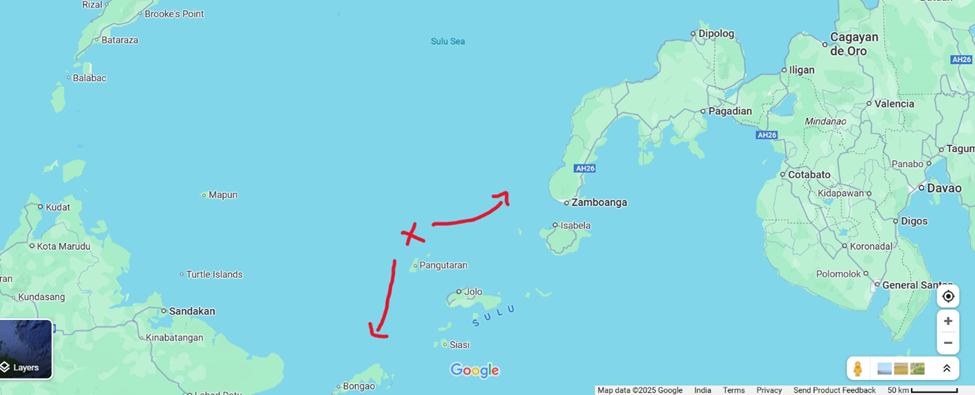

*The cross roughly shows the crash site. The arrows show the two general directions debris is carried along.*

# Part II - Estimating Flows with Gaussian Processes.





## Gaussian Process Modeling for Flow Field Velocities

To model a **Gaussian Process (GP)** for the flow field, we select a **Radial Basis Function (RBF)** or **Squared Exponential kernel** to capture the correlation in velocity with time at a fixed location. The kernel between two time instances $ t_1, t_2 $ is defined as:

$
K(t_1, t_2) = a^2 \exp\left(-\frac{(t_1 - t_2)^2}{l^2}\right)
$

where the parameter set is defined by $ \theta = \{a, l\} $.  
The RBF kernel is a natural choice because it reflects the real physical behavior of fluid flows: that points closer in time are more strongly correlated. It also provides smooth variations, is differentiable, and guarantees positive definiteness.

---

### Hyperparameter Optimization

We performed grid search over:

- $ a \in [0.1, 5] $
- $ l \in [0.1, 5] $

using **k-fold cross-validation**. The **average predictive log-likelihood** across folds was used as the selection criterion. For each fold, the test set predictive distribution was defined using:

$
\mu_{\text{test}|\text{train}} = K_{\text{cross}} (K_{\text{train}} + \tau I)^{-1} y_{\text{train}}
$

$
K_{\text{test}|\text{train}} = K_{\text{test}} - K_{\text{cross}}^T (K_{\text{train}} + \tau I)^{-1} K_{\text{cross}}
$

where the mean was initialized to zero for both training and test sets. The kernel matrix $ K $ was computed using the RBF definition, and we fixed $ \tau = 0.001 $.

We selected the hyperparameters that maximized the **average log-likelihood**:

$
\log \mathcal{L} = -\frac{1}{2} (y_{\text{test}} - \mu_{\text{test}})^T K^{-1} (y_{\text{test}} - \mu_{\text{test}})
- \frac{1}{2} \log |K_{\text{test}}| - \frac{1}{2} n_{\text{test}} \log (2\pi)
$


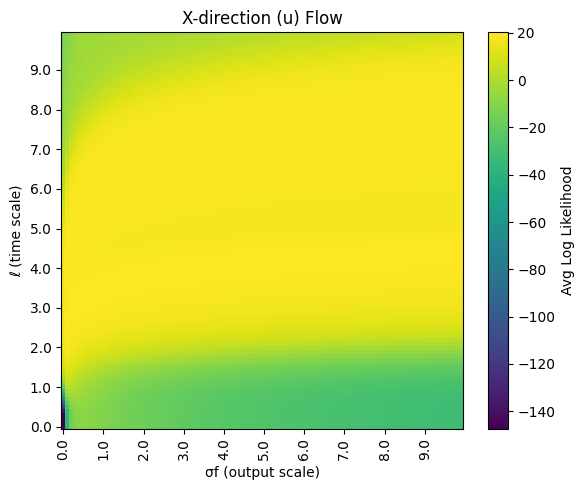

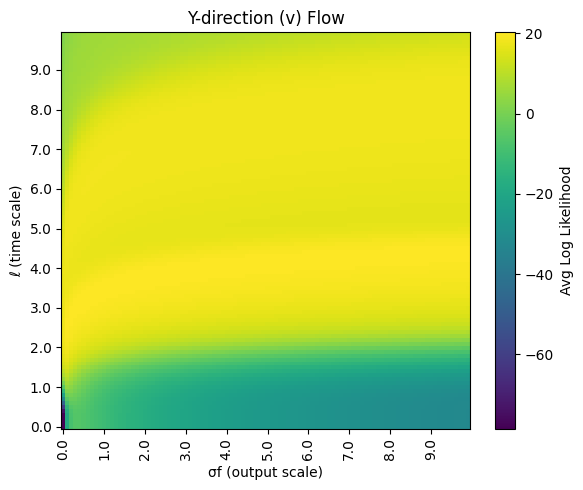


--- Best Parameters for u (X-direction) ---
✅ Best Parameters:
  ℓ (time  scale): 3.5000
  a (output scale): 0.8000
  Avg Log Likelihood: 20.2427

--- Best Parameters for v (Y-direction) ---
✅ Best Parameters:
  ℓ (time  scale): 3.7000
  a (output scale): 1.4000
  Avg Log Likelihood: 20.2684


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from sklearn.model_selection import KFold

# Location selection
y_loc = 400
x_loc = 400

u_flow_at_location = u_stack[:, y_loc, x_loc]
v_flow_at_location = v_stack[:, y_loc, x_loc]

# RBF Kernel Function
def rbf_kernel(x1, x2, length_scale, sigma_f):
    sqdist = np.subtract.outer(x1, x2)**2
    return sigma_f**2 * np.exp(-1.0 * sqdist / length_scale**2)


def gp_predict(x_train, y_train, x_test, length_scale, sigma_f, tau=0.001):
    K_train = rbf_kernel(x_train, x_train, length_scale, sigma_f) + tau * np.eye(len(x_train))  # Train-train
    K_cross = rbf_kernel(x_train, x_test, length_scale, sigma_f)                                # Train-test
    K_test = rbf_kernel(x_test, x_test, length_scale, sigma_f) + tau * np.eye(len(x_test))      # Test-test

    # Solve for alpha
    alpha = np.linalg.solve(K_train, y_train)

    # Predictive mean
    mu = K_cross.T @ alpha

    # Predictive covariance
    K_inv_Ks = np.linalg.solve(K_train, K_cross)
    cov = K_test - K_cross.T @ K_inv_Ks

    return mu.flatten(), cov



# Log Likelihood Function
def log_likelihood(y_test, mu, cov):
    residual = y_test - mu
    try:
        sign, logdet = np.linalg.slogdet(cov)
        if sign <= 0:
            return -np.inf
        inv_cov = np.linalg.inv(cov)
        return -0.5 * residual @ inv_cov @ residual - 0.5 * logdet - 0.5 * len(y_test) * np.log(2 * np.pi)
    except np.linalg.LinAlgError:
        return -np.inf



# Cross-validation over hyperparameters
def cross_val_gp(y_data, l_vals, sigma_f_vals, tau=0.001):
    t = np.arange(len(y_data))
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    results = {}

    for l in l_vals:
        for sigma_f in sigma_f_vals:
            total_ll = 0
            for train_idx, test_idx in kf.split(t):
                x_train, y_train = t[train_idx], y_data[train_idx]
                x_test, y_test = t[test_idx], y_data[test_idx]
                mu, cov = gp_predict(x_train, y_train, x_test, l, sigma_f, tau=tau)
                total_ll += log_likelihood(y_test, mu, cov)
            results[(l, sigma_f)] = total_ll / 10
    return results

# Heatmap Plotting
def plot_results(results, l_vals, sigma_f_vals, title):
    Z = np.array([[results.get((l, sf), -np.inf) for sf in sigma_f_vals] for l in l_vals])
    plt.figure(figsize=(6, 5))
    plt.imshow(Z, origin='lower', aspect='auto', cmap='viridis')
    skip_x = 10  # Show every 3rd sigma_f value
    skip_y = 10  # Show every 2nd l value

    plt.xticks(
        range(0, len(sigma_f_vals), skip_x),
        np.round(sigma_f_vals[::skip_x], 0),
        rotation=90
    )
    plt.yticks(
        range(0, len(l_vals), skip_y),
        np.round(l_vals[::skip_y], 0)
    )
    plt.xlabel("σf (output scale)")
    plt.ylabel("ℓ (time scale)")
    plt.title(title)
    plt.colorbar(label="Avg Log Likelihood")
    plt.tight_layout()
    plt.show()

# Hyperparameter grid
sigma_f_vals = np.linspace(0.1, 10.0, 100)
l_vals = np.linspace(0.1, 10.0, 100)

# Run GP cross-validation
results_u = cross_val_gp(u_flow_at_location, l_vals, sigma_f_vals)
plot_results(results_u, l_vals, sigma_f_vals, "X-direction (u) Flow")

results_v = cross_val_gp(v_flow_at_location, l_vals, sigma_f_vals)
plot_results(results_v, l_vals, sigma_f_vals, "Y-direction (v) Flow")

# Extract and print best hyperparameters
def get_best_params(results):
    best_params = max(results.items(), key=lambda x: x[1])
    (best_l, best_sigma_f), best_ll = best_params
    print(f"✅ Best Parameters:")
    print(f"  ℓ (time  scale): {best_l:.4f}")
    print(f"  a (output scale): {best_sigma_f:.4f}")
    print(f"  Avg Log Likelihood: {best_ll:.4f}")
    return best_l, best_sigma_f

print("\n--- Best Parameters for u (X-direction) ---")
best_l_u, best_sf_u = get_best_params(results_u)

print("\n--- Best Parameters for v (Y-direction) ---")
best_l_v, best_sf_v = get_best_params(results_v)


In [ ]:
# Hyperparameter grid
sigma_f_vals = np.linspace(0.1, 5.0, 100)
l_vals = np.linspace(0.1, 5.0, 100)

In [ ]:
# Define the 4 locations as (y, x) tuples
locations = [(100, 100),
            (200, 300),
            (400, 400),
            (400, 100)] #[(400, 400), (300, 300), (250, 450), (100, 100)]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.3)

# Loop through each location
for i, (x_loc, y_loc) in enumerate(locations):
    print(f"\n=== 🔍 Location {i+1}: (y={y_loc}, x={x_loc}) ===")

    u_flow_at_location = u_stack[:, y_loc, x_loc]
    v_flow_at_location = v_stack[:, y_loc, x_loc]

    # Run cross-validation
    results_u = cross_val_gp(u_flow_at_location, l_vals, sigma_f_vals, tau=0.001)
    results_v = cross_val_gp(v_flow_at_location, l_vals, sigma_f_vals, tau=0.001)

    # Build heatmap matrix for u and v
    Z_u = np.array([[results_u.get((l, sf), -np.inf) for sf in sigma_f_vals] for l in l_vals])
    Z_v = np.array([[results_v.get((l, sf), -np.inf) for sf in sigma_f_vals] for l in l_vals])

    # Plot for u (top row)
    ax_u = axes[0, i]
    im_u = ax_u.imshow(Z_u, origin='lower', aspect='auto', cmap='viridis')
    ax_u.set_title(f"u-flow - Loc {i+1}")
    ax_u.set_xticks(range(0, len(sigma_f_vals), 10))
    ax_u.set_xticklabels(np.round(sigma_f_vals[::10], 1), rotation=90)
    ax_u.set_yticks(range(0, len(l_vals), 10))
    ax_u.set_yticklabels(np.round(l_vals[::10], 1))
    ax_u.set_xlabel("σf")
    ax_u.set_ylabel("ℓ")
    fig.colorbar(im_u, ax=ax_u, fraction=0.046, pad=0.04)

    # Plot for v (bottom row)
    ax_v = axes[1, i]
    im_v = ax_v.imshow(Z_v, origin='lower', aspect='auto', cmap='viridis')
    ax_v.set_title(f"v-flow - Loc {i+1}")
    ax_v.set_xticks(range(0, len(sigma_f_vals), 10))
    ax_v.set_xticklabels(np.round(sigma_f_vals[::10], 1), rotation=90)
    ax_v.set_yticks(range(0, len(l_vals), 10))
    ax_v.set_yticklabels(np.round(l_vals[::10], 1))


    ax_v.set_xlabel("σf")
    ax_v.set_ylabel("ℓ")
    fig.colorbar(im_v, ax=ax_v, fraction=0.046, pad=0.04)

    # Print best hyperparameters
    print(f"\n--- Best Parameters for u (X-direction) at Location {i+1} ---")
    best_l_u, best_sf_u = get_best_params(results_u)

    print(f"\n--- Best Parameters for v (Y-direction) at Location {i+1} ---")
    best_l_v, best_sf_v = get_best_params(results_v)

plt.suptitle("GP Hyperparameter Log Likelihoods for u- and v-flows at 4 Locations", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


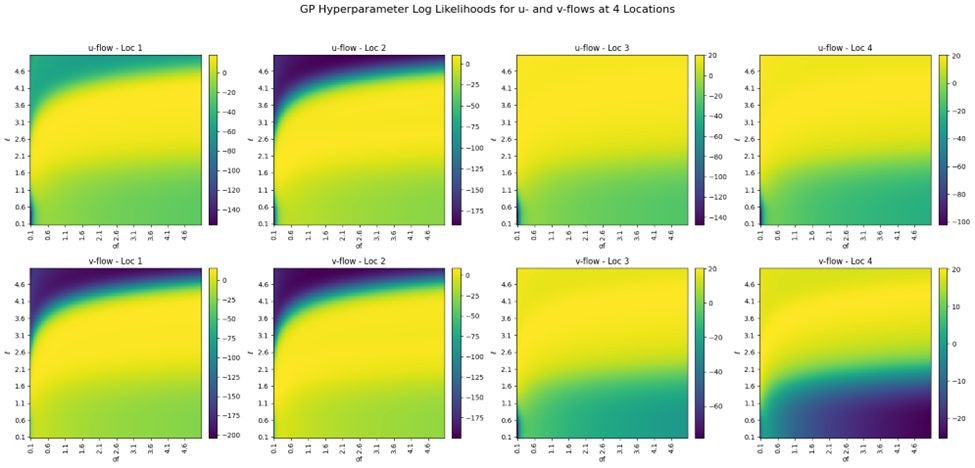



Figure presents the optimization heatmap over the $ (a, l) $ grid. The x-axis denotes the prefactor $ a_{x}, a_{y} $, and the y-axis denotes the time scale $ l_{x}, l_{y} $. Yellow indicates high predictive likelihood; purple indicates low likelihood.

---

### Optimized Parameters

| Location           | Optimal $ l_x, l_y $ | Optimal $ a_x, a_y $ | Avg. Log Likelihood |
|-------------------|------------------------|------------------------|---------------------|
| (100, 100)        | 3.91, 3.81             | 5.00, 5.00             | 17.98, 15.48        |
| (200, 300)        | 2.03, 1.63             | 0.40, 0.25             | 10.39, 8.52         |
| (400, 400)        | 3.37, 3.66             | 0.59, 1.34             | 20.25, 20.27        |
| (400, 100)        | 3.22, 3.07             | 0.55, 0.35             | 20.28, 20.25        |

---

### Interpretation

- The **time scale $ l $** for locations 1, 3, and 4 ranges between **3 and 4**, which translates to approximately **216–288 hours** (since the sampling interval is 72 hours).
  - This suggests smoother and more stable variations in velocity.
  - Location 2 has $ l \sim 2 \Rightarrow 144 $ hours, indicating more **rapidly changing currents**, possibly due to its proximity to the mainland coast.

- The **prefactor $ a $**:
  - For location 1, it hits the upper grid limit (5.0), indicating the model's uncertainty or strong signal strength in that region.
  - For the other locations, $ a \sim 1 \pm 0.5 $, reflecting moderate variability.

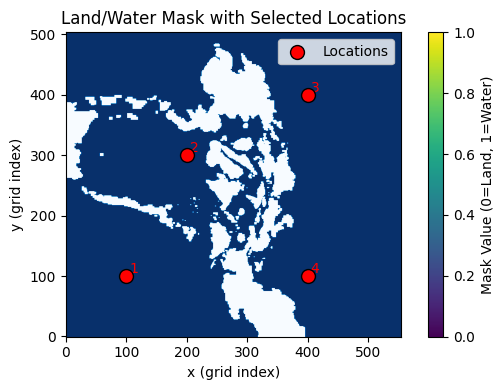

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the mask (0 = land, 1 = water)
mask = pd.read_csv("OceanFlow/mask.csv", header=None).to_numpy()


# Extract x and y for plotting
xs,ys = zip(*locations)

# Plot
plt.figure(figsize=(6, 4))
plt.imshow(mask, cmap="Blues", origin='lower')  # origin='lower' to match (0,0) at bottom-left
plt.scatter(xs, ys, color='red', edgecolor='black', s=100, label='Locations', zorder=10)
for i, (x, y) in enumerate(locations):
    plt.text(x + 5, y + 5, f'{i+1}', color='red', fontsize=10)

plt.title("Land/Water Mask with Selected Locations")
plt.xlabel("x (grid index)")
plt.ylabel("y (grid index)")
plt.colorbar(label="Mask Value (0=Land, 1=Water)")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()



### Results for Selected Locations

We modeled the **horizontal (u_x)** and **vertical (u_y)** velocity components over time for the following grid locations:

- $ (100, 100) $
- $ (200, 300) $
- $ (400, 400) $
- $ (400, 100) $

Figure shows the selected locations.  

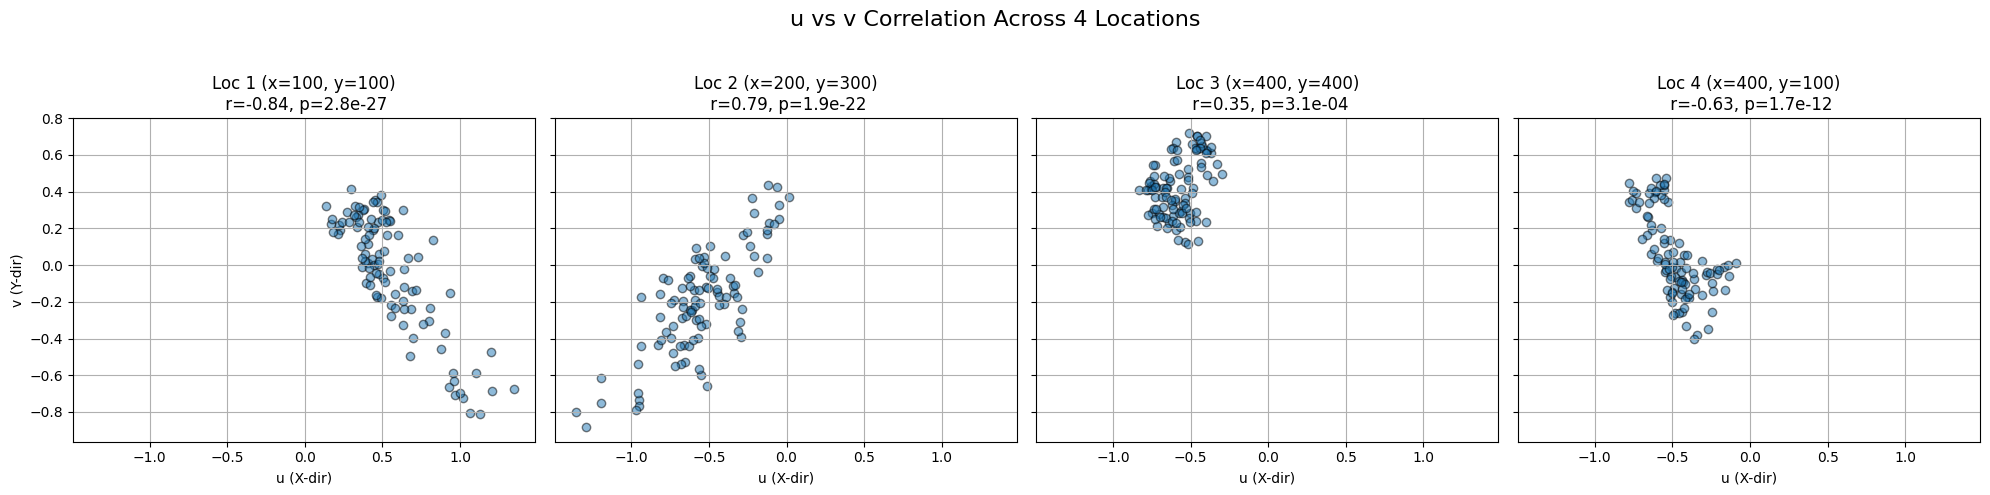

In [ ]:

import matplotlib.pyplot as plt
from scipy.stats import pearsonr


# Create 1x4 subplot
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

for i, (x_loc, y_loc) in enumerate(locations):
    u_series = u_stack[:, y_loc, x_loc]
    v_series = v_stack[:, y_loc, x_loc]

    # Pearson correlation
    corr_coef, p_val = pearsonr(u_series, v_series)

    ax = axes[i]
    ax.scatter(u_series, v_series, alpha=0.5, edgecolor='k')
    ax.set_xlabel("u (X-dir)")
    ax.set_title(f"Loc {i+1} (x={x_loc}, y={y_loc})\n r={corr_coef:.2f}, p={p_val:.1e}")
    ax.grid(True)

axes[0].set_ylabel("v (Y-dir)")
plt.suptitle("u vs v Correlation Across 4 Locations", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


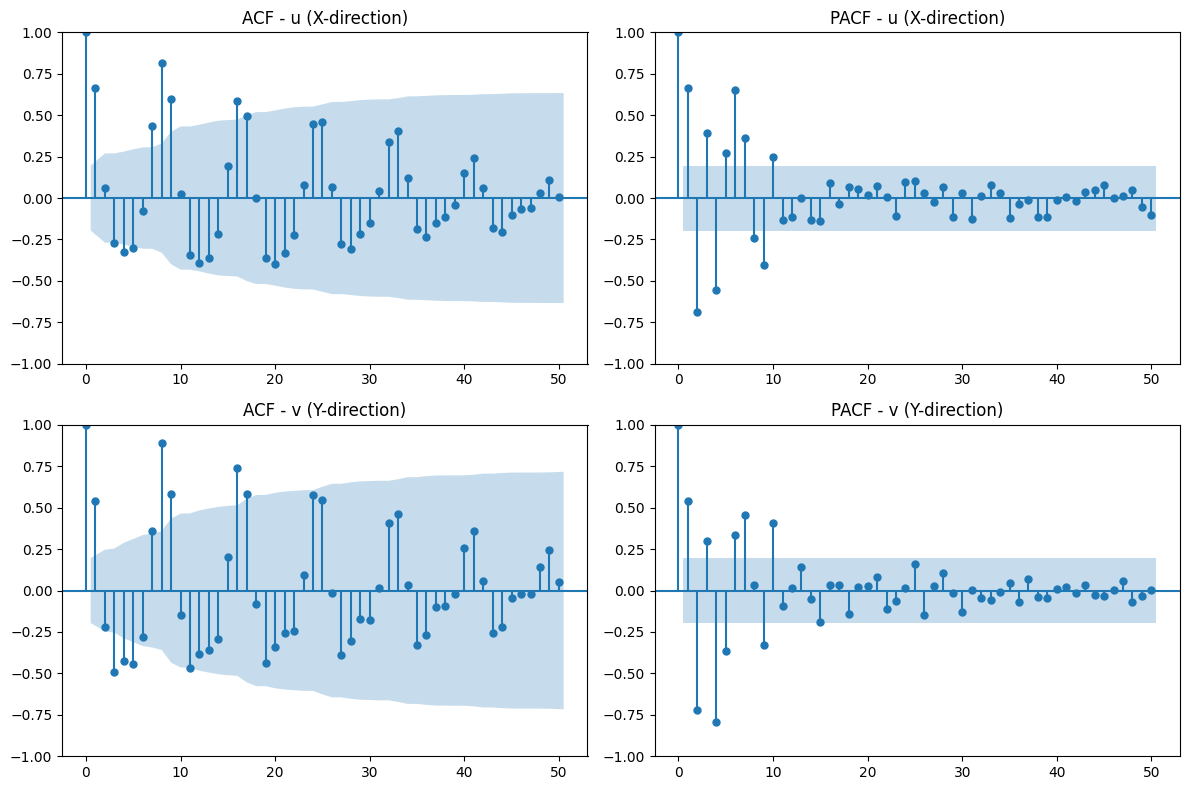

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Location
y_loc, x_loc = 100, 100

# Time series
u_series = u_stack[:, y_loc, x_loc]
v_series = v_stack[:, y_loc, x_loc]

# Plotting ACF and PACF
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# u series
plot_acf(u_series, ax=axes[0, 0], lags=50, title="ACF - u (X-direction)")
plot_pacf(u_series, ax=axes[0, 1], lags=50, title="PACF - u (X-direction)")

# v series
plot_acf(v_series, ax=axes[1, 0], lags=50, title="ACF - v (Y-direction)")
plot_pacf(v_series, ax=axes[1, 1], lags=50, title="PACF - v (Y-direction)")

plt.tight_layout()
plt.show()


## Different noise level tau

The Gaussian Process (GP) simulation was rerun for the location (200, 300) with different values of the noise parameter
$\tau \in {0.001,,0.01,,0.1}$.
The parameter $\tau$ controls the strength of observational noise and reflects our uncertainty in the measurements.
A small jitter term such as $\tau$ is also commonly added to the covariance matrix to mitigate numerical instability during inversion.

The optimization was performed over an expanded hyperparameter grid with:

$a \in [0.1, 10]$

$l \in [0.1, 10]$

The corresponding predictive log-likelihood heatmaps are shown in Figure 11.

Yellow indicates high likelihood; purple indicates low likelihood regions.

Figure 11: Heatmap of predictive likelihood over the $(l_x, l_y)$ and $(a_x, a_y)$ grid for location (200, 300) across different values of $\tau$.

$\tau$	Optimal $(l_x, l_y)$	Optimal $(a_x, a_y)$
0.001	(2.0, 1.7)	(0.4, 0.3)
0.01	(3.8, 3.7)	(9.0, 7.0)
0.1	(10.0, 10.0)	(0.7, 0.2)

As $\tau$ increases, the optimal correlation time-scale $l$ also increases.
This behavior is expected because higher noise reduces the model’s sensitivity to short-term variations, thus favoring smoother (longer-scale) correlations.

For $\tau = 0.01$, the amplitude values $(a_x, a_y)$ are unusually large. However, this is likely an artifact:
the likelihood surface appears flat for $a > 0.5$, suggesting a wide range of $a$ values yield similar model performance.

In the case of $\tau = 0.1$, the optimizer converges at the boundary value $l = 10$.
Even when the search range is extended beyond 10, the optimal $l$ remains at the upper limit.
This indicates convergence issues—suggesting the model treats the data as predominantly noise, making it difficult to resolve meaningful structure.
Such flat or ill-defined likelihood surfaces limit the interpretability of the learned hyperparameters.


--- Best Parameters for u (X-direction) ---
✅ Best Parameters for 𝜏 = 0.001:
  ℓ (time scale): 2.0000
  a (output scale): 0.4000
  Avg Log Likelihood: 10.3646

--- Best Parameters for v (Y-direction) ---
✅ Best Parameters for 𝜏 = 0.001:
  ℓ (time scale): 1.7000
  a (output scale): 0.3000
  Avg Log Likelihood: 8.4442

--- Best Parameters for u (X-direction) ---
✅ Best Parameters for 𝜏 = 0.01:
  ℓ (time scale): 3.8000
  a (output scale): 9.0000
  Avg Log Likelihood: 7.5439

--- Best Parameters for v (Y-direction) ---
✅ Best Parameters for 𝜏 = 0.01:
  ℓ (time scale): 3.7000
  a (output scale): 7.0000
  Avg Log Likelihood: 7.3542

--- Best Parameters for u (X-direction) ---
✅ Best Parameters for 𝜏 = 0.1:
  ℓ (time scale): 4.7000
  a (output scale): 0.7000
  Avg Log Likelihood: -1.3465

--- Best Parameters for v (Y-direction) ---
✅ Best Parameters for 𝜏 = 0.1:
  ℓ (time scale): 10.0000
  a (output scale): 0.2000
  Avg Log Likelihood: -0.9148


C:\Users\bisht\AppData\Local\Temp\ipykernel_6752\2717194061.py:76: UserWarning: Glyph 120591 (\N{MATHEMATICAL ITALIC SMALL TAU}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
C:\Users\bisht\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 120591 (\N{MATHEMATICAL ITALIC SMALL TAU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


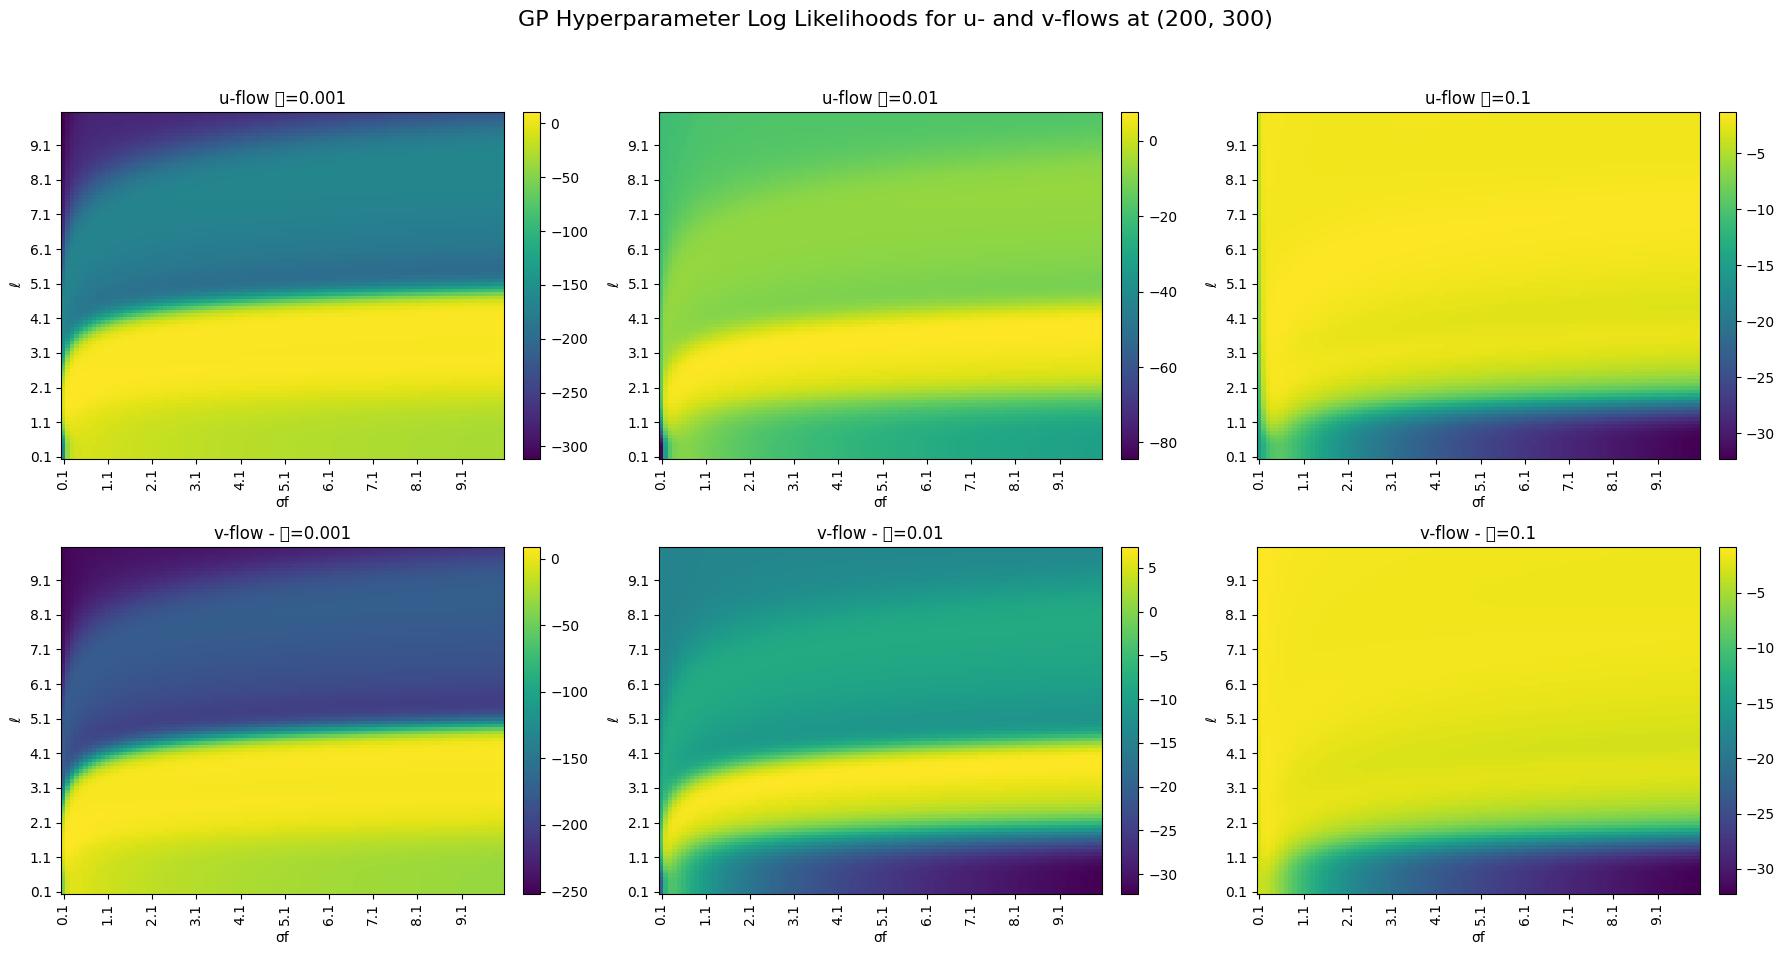

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from sklearn.model_selection import KFold

# Location selection
y_loc = 300
x_loc = 200

u_flow_at_location = u_stack[:, y_loc, x_loc]
v_flow_at_location = v_stack[:, y_loc, x_loc]

tau_list = [0.001, 0.01, 0.1]

 # Extract and print best hyperparameters
def get_best_params(results):
    best_params = max(results.items(), key=lambda x: x[1])
    (best_l, best_sigma_f), best_ll = best_params
    print(f"✅ Best Parameters for 𝜏 = {tau}:")
    print(f"  ℓ (time scale): {best_l:.4f}")
    print(f"  a (output scale): {best_sigma_f:.4f}")
    print(f"  Avg Log Likelihood: {best_ll:.4f}")
    return best_l, best_sigma_f


n_tau = len(tau_list)
fig, axes = plt.subplots(2, n_tau, figsize=(6 * n_tau, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.3)


for i, tau in enumerate(tau_list):
    # Run GP cross-validation
    results_u = cross_val_gp(u_flow_at_location, l_vals, sigma_f_vals,  tau=tau)

    results_v = cross_val_gp(v_flow_at_location, l_vals, sigma_f_vals,  tau=tau)

    print("\n--- Best Parameters for u (X-direction) ---")
    best_l_u, best_sf_u = get_best_params(results_u)

    print("\n--- Best Parameters for v (Y-direction) ---")
    best_l_v, best_sf_v = get_best_params(results_v)


    # Build heatmap matrix for u and v
    Z_u = np.array([[results_u.get((l, sf), -np.inf) for sf in sigma_f_vals] for l in l_vals])
    Z_v = np.array([[results_v.get((l, sf), -np.inf) for sf in sigma_f_vals] for l in l_vals])

    # Plot for u (top row)
    ax_u = axes[0, i]
    im_u = ax_u.imshow(Z_u, origin='lower', aspect='auto', cmap='viridis')
    ax_u.set_title(f"u-flow 𝜏={tau}")
    ax_u.set_xticks(range(0, len(sigma_f_vals), 10))
    ax_u.set_xticklabels(np.round(sigma_f_vals[::10], 1), rotation=90)
    ax_u.set_yticks(range(0, len(l_vals), 10))
    ax_u.set_yticklabels(np.round(l_vals[::10], 1))
    ax_u.set_xlabel("σf")
    ax_u.set_ylabel("ℓ")
    fig.colorbar(im_u, ax=ax_u, fraction=0.046, pad=0.04)

    # Plot for v (bottom row)
    ax_v = axes[1, i]
    im_v = ax_v.imshow(Z_v, origin='lower', aspect='auto', cmap='viridis')
    ax_v.set_title(f"v-flow - 𝜏={tau}")
    ax_v.set_xticks(range(0, len(sigma_f_vals), 10))
    ax_v.set_xticklabels(np.round(sigma_f_vals[::10], 1), rotation=90)
    ax_v.set_yticks(range(0, len(l_vals), 10))
    ax_v.set_yticklabels(np.round(l_vals[::10], 1))


    ax_v.set_xlabel("σf")
    ax_v.set_ylabel("ℓ")
    fig.colorbar(im_v, ax=ax_v, fraction=0.046, pad=0.04)


plt.suptitle(f"GP Hyperparameter Log Likelihoods for u- and v-flows at {x_loc, y_loc}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Modelling Gaussian Process using Scikit-learn

We use the GaussianProcessRegressor from the Python library scikit-learn to model the time series velocity at the four locations specified in Problem 4a.

The kernel is defined as:

python
Copy
Edit
kernel = ConstantKernel(length_scale=1.0, length_scale_bounds=(0.1, 10.0)) * RBF(length_scale=1.0, length_scale_bounds=(0.1, 10.0))
This is equivalent to the squared exponential kernel used previously.

The ConstantKernel term corresponds to the signal variance $a^2$.

The RBF term corresponds to the length-scale parameter $l$.

The length_scale_bounds arguments define the search space for these hyperparameters.

We initialize the GP regressor as follows:

gp = GaussianProcessRegressor(kernel=kernel, alpha=0.001, normalize_y=True, n_restarts_optimizer=10)
alpha = 0.001 corresponds to the noise parameter $\tau$.

normalize_y=True ensures the training data is normalized before fitting.

n_restarts_optimizer=10 enables multi-start optimization with 10 random initializations to avoid poor local optima.

The regressor optimizes the hyperparameters by maximizing the log marginal likelihood over the full dataset.

Optimized hyperparameters at each location:

Location (y, x)	Optimal $(l_x, l_y)$	Optimal $\hat{a}_x, \hat{a}_y$
(100, 100)	(1.87, 1.45)	(0.569, 0.405)
(300, 200)	(1.52, 1.25)	(0.559, 0.349)
(400, 400)	(3.81, 3.85)	(0.508, 0.380)
(100, 400)	(4.29, 3.82)	(0.385, 0.316)

Discussion:

Scikit-learn optimizes using the log marginal likelihood over the full dataset,
whereas earlier approaches relied on cross-validated predictive log-likelihood over partial folds.
This difference in objective function can lead to slightly different optimal values.

Nevertheless, the hyperparameters obtained using Scikit-learn are consistent in order of magnitude with the manual optimization results for locations 2–4.

Notably, for the location (100, 100), the variance prefactor now yields a stable solution within the grid.
This improvement can be attributed to the n_restarts_optimizer setting, which increases the chance of converging to a better global solution by avoiding poor local minima.

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
# Define the 4 locations as (y, x) tuples
locations = [(100, 100),
            (200, 300),
            (400, 400),
            (400, 100)] #[(400, 400), (300, 300), (250, 450), (100, 100)]


=== 🔍 Location 1: (y=100, x=100) ===

--- Best Parameters for uₓ at Location 1 ---
  ℓ (length scale): 1.9000
  σf (output scale): 0.6000
  Log Marginal Likelihood: 50.0115

--- Best Parameters for uᵧ at Location 1 ---
  ℓ (length scale): 1.4000
  σf (output scale): 0.4000
  Log Marginal Likelihood: 35.8765

=== 🔍 Location 2: (y=300, x=200) ===

--- Best Parameters for uₓ at Location 2 ---
  ℓ (length scale): 1.5000
  σf (output scale): 0.6000
  Log Marginal Likelihood: 7.2074

--- Best Parameters for uᵧ at Location 2 ---
  ℓ (length scale): 1.3000
  σf (output scale): 0.4000
  Log Marginal Likelihood: 19.5120

=== 🔍 Location 3: (y=400, x=400) ===

--- Best Parameters for uₓ at Location 3 ---
  ℓ (length scale): 3.8000
  σf (output scale): 0.5000
  Log Marginal Likelihood: 121.2132

--- Best Parameters for uᵧ at Location 3 ---
  ℓ (length scale): 3.9000
  σf (output scale): 0.4000
  Log Marginal Likelihood: 123.4924

=== 🔍 Location 4: (y=100, x=400) ===

--- Best Parameters for uₓ at 

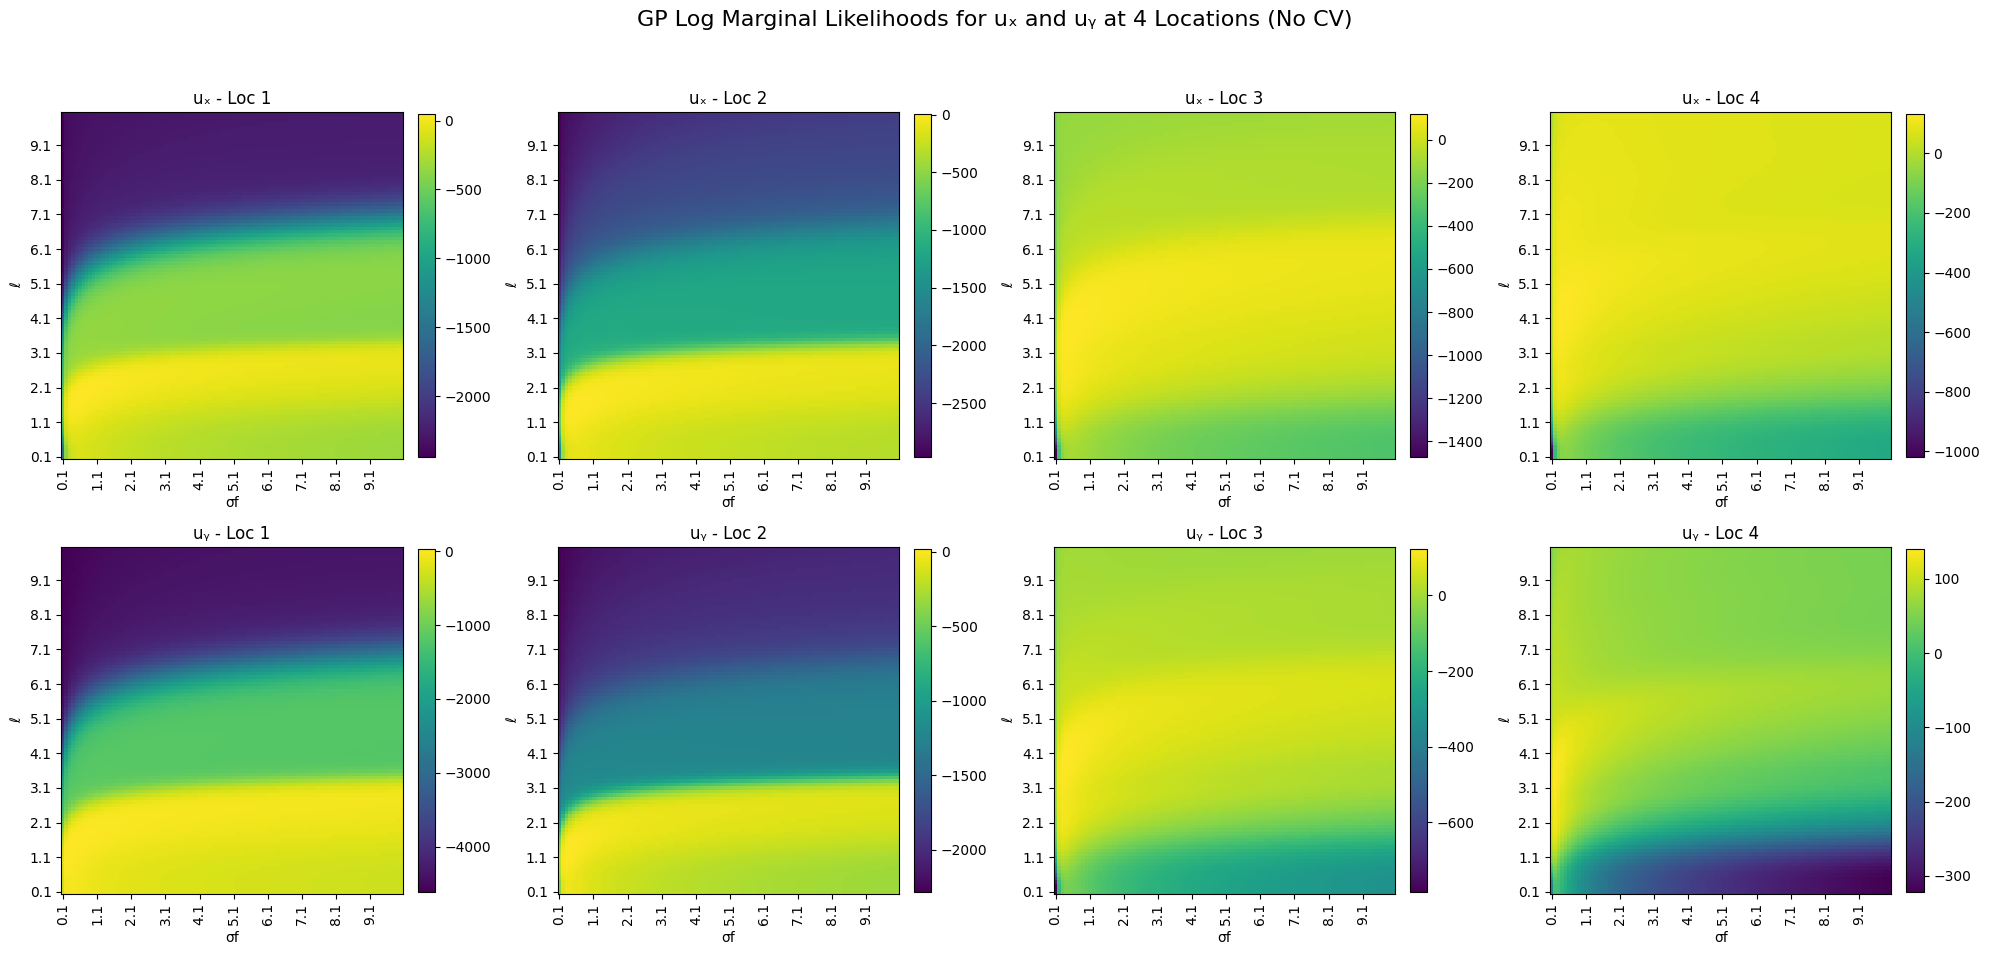

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Define parameter grid
l_vals = np.linspace(0.1, 10.0, 100)
sigma_f_vals = np.linspace(0.1, 10.0, 100)

# Define locations as (x, y) for (column, row)
locations = [(100, 100), (200, 300), (400, 400), (400, 100)]

# Create figure and axes
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.3)

# Time axis
t = np.arange(u_stack.shape[0])

# Process each location
for i, (x_loc, y_loc) in enumerate(locations):
    print(f"\n=== 🔍 Location {i+1}: (y={y_loc}, x={x_loc}) ===")

    for flow_idx, (flow_stack, label) in enumerate([(u_stack, 'uₓ'), (v_stack, 'uᵧ')]):
        y_data = flow_stack[:, y_loc, x_loc]

        # Initialize log-likelihood matrix
        log_likelihood_grid = np.zeros((len(l_vals), len(sigma_f_vals)))

        # Loop over hyperparameter grid
        for i_l, l in enumerate(l_vals):
            for i_sf, sf in enumerate(sigma_f_vals):
                kernel = C(sf**2) * RBF(length_scale=l)
                gp = GaussianProcessRegressor(kernel=kernel, alpha=0.001, normalize_y=False, optimizer=None)

                try:
                    gp.fit(t.reshape(-1, 1), y_data)
                    ll = gp.log_marginal_likelihood()
                except Exception as e:
                    ll = -np.inf  # Handle fitting errors
                log_likelihood_grid[i_l, i_sf] = ll

        # Plot heatmap
        ax = axes[flow_idx, i]
        im = ax.imshow(log_likelihood_grid, origin='lower', aspect='auto', cmap='viridis')
        ax.set_title(f"{label} - Loc {i+1}")
        ax.set_xticks(range(0, len(sigma_f_vals), 10))
        ax.set_xticklabels(np.round(sigma_f_vals[::10], 1), rotation=90)
        ax.set_yticks(range(0, len(l_vals), 10))
        ax.set_yticklabels(np.round(l_vals[::10], 1))
        ax.set_xlabel("σf")
        ax.set_ylabel("ℓ")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        # Extract and print best parameters
        idx_best = np.unravel_index(np.argmax(log_likelihood_grid), log_likelihood_grid.shape)
        best_l = l_vals[idx_best[0]]
        best_sf = sigma_f_vals[idx_best[1]]
        print(f"\n--- Best Parameters for {label} at Location {i+1} ---")
        print(f"  ℓ (length scale): {best_l:.4f}")
        print(f"  σf (output scale): {best_sf:.4f}")
        print(f"  Log Marginal Likelihood: {log_likelihood_grid[idx_best]:.4f}")

plt.suptitle("GP Log Marginal Likelihoods for uₓ and uᵧ at 4 Locations (No CV)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Gaussian Process Interpolation

To estimate flow values at a finer temporal resolution, we applied **Gaussian Process (GP) regression** using the hyperparameters obtained in **Problem 4**.

The original dataset includes **100 observations** recorded every **3 days** (i.e., on days 0, 3, 6, ..., 297). To enhance temporal resolution for consistency with downstream forward models, we interpolated the flow values to a **daily timescale**, effectively introducing **two new predictions** between each pair of observed values. This approach balances granularity with computational cost.

We used the **GP posterior** to compute both the **conditional mean** and **covariance** at the missing daily timestamps. Key components of the model:

- **Prior mean:** Zero  
- **Kernel:** Radial Basis Function (RBF)  
- **Hyperparameters:** Tuned values of length scale, output scale, and noise variance from Problem 4  
- **Numerical stability:** A small jitter term was added to the covariance matrix to ensure robust inversion

---

**Visualization:**

The predicted **mean** flow values and **3σ uncertainty bands** were plotted for both **u-flow** and **v-flow** components at each of the four selected locations.

- The uncertainty bands reflect the posterior predictive distribution, capturing the model’s confidence in its interpolation.
- Results show that interpolation using a GP provides a smooth and probabilistically grounded estimate of the flow field at finer temporal scales.

---



================== Location 1 — (100, 100) ==================



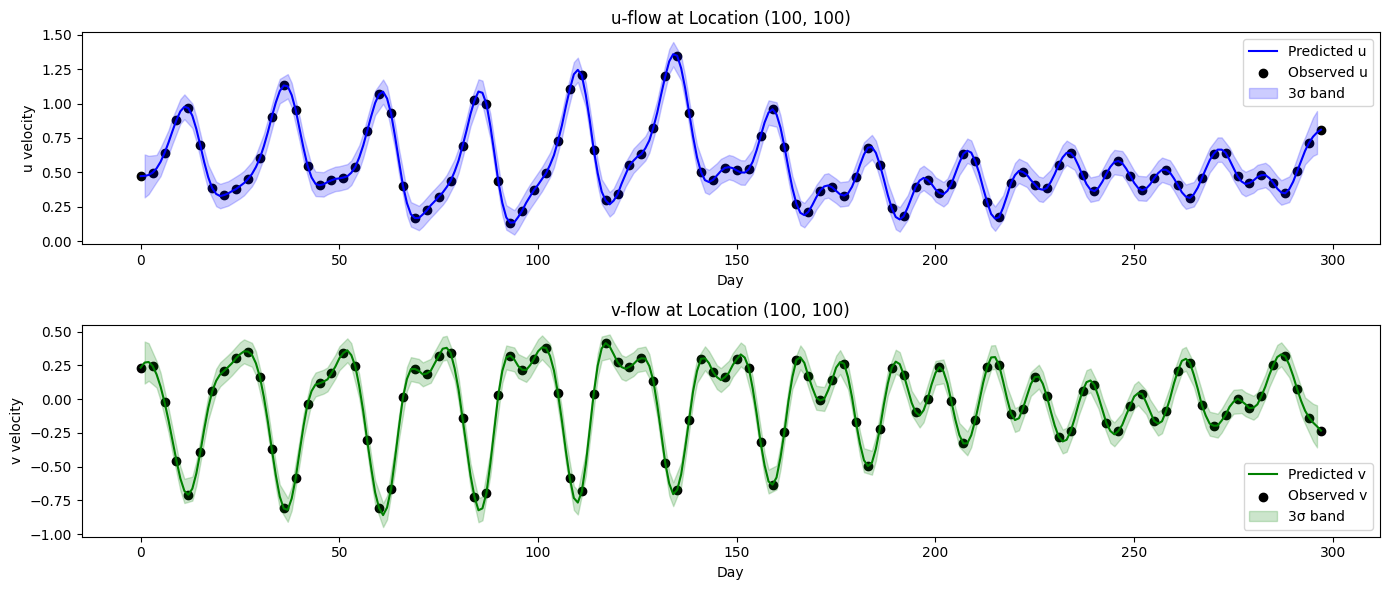


================== Location 2 — (300, 200) ==================



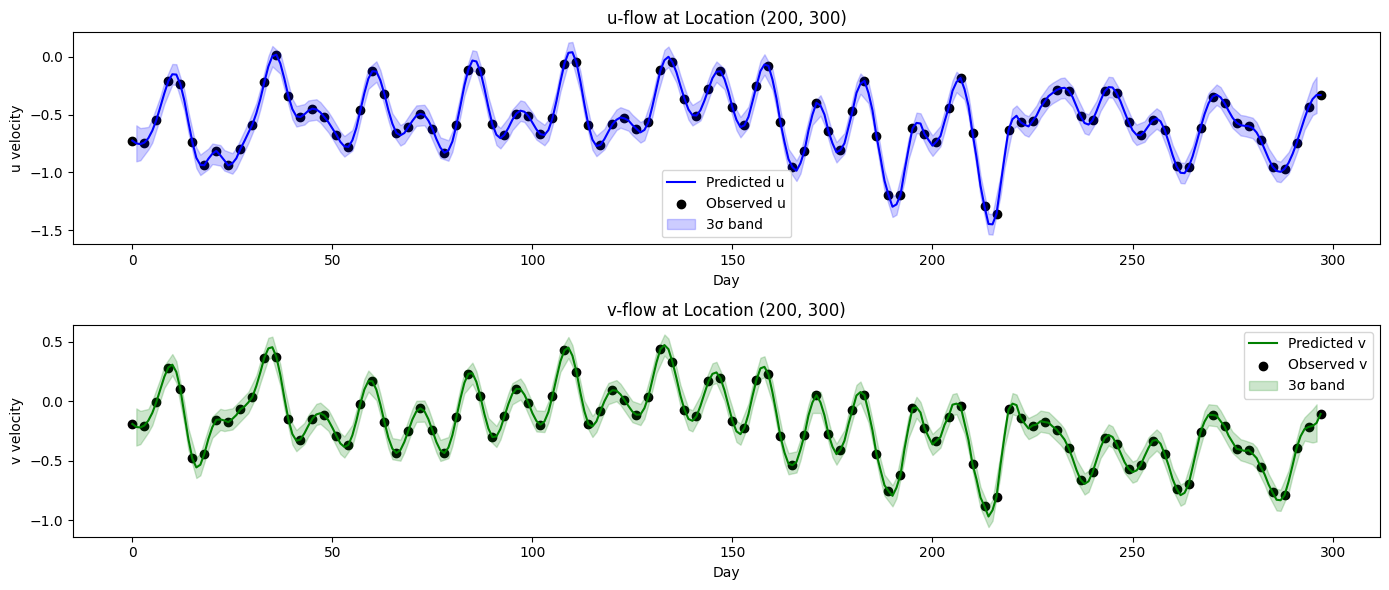


================== Location 3 — (400, 400) ==================



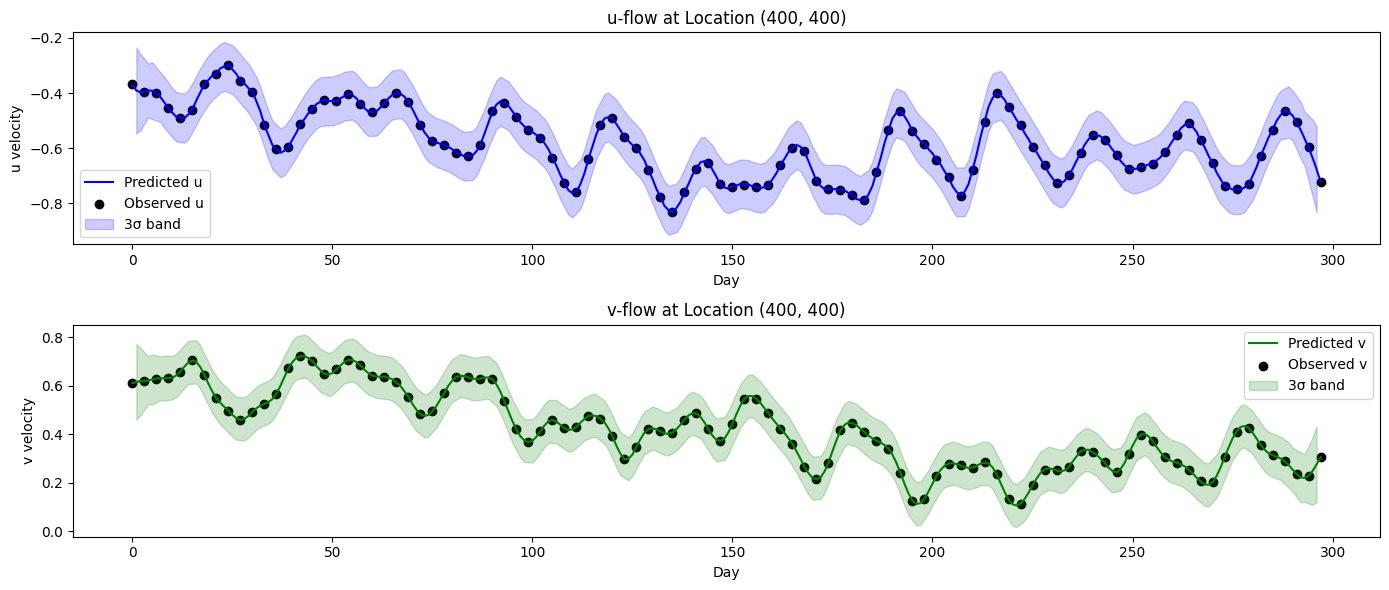


================== Location 4 — (100, 400) ==================



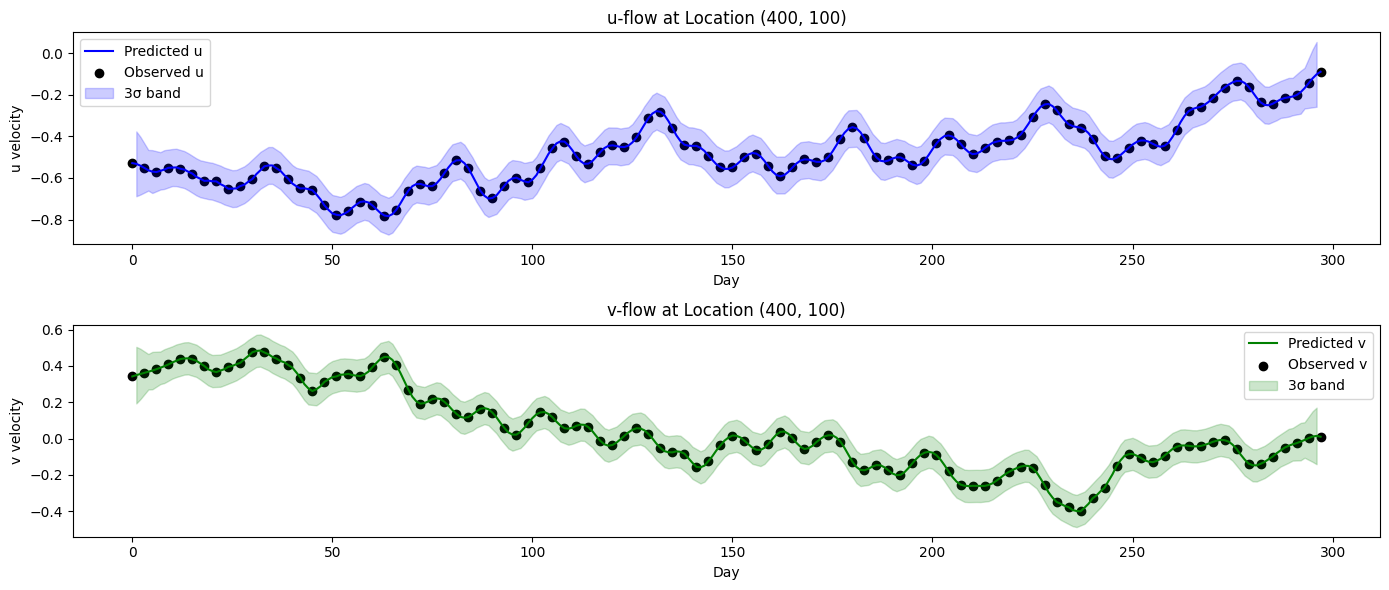

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---  manual GP prediction function ---
def gaussian_process_predict(x_obs, x_pred, y_obs, length_scale=5.0, sigma_f=1.0, sigma_y=0.001):
    def rbf_kernel(a, b, length_scale, sigma_f):
        sqdist = np.subtract.outer(a, b)**2
        return sigma_f**2 * np.exp(-0.5 * sqdist / length_scale**2)

    K = rbf_kernel(x_obs, x_obs, length_scale, sigma_f) + sigma_y * np.eye(len(x_obs))
    K_s = rbf_kernel(x_obs, x_pred, length_scale, sigma_f)
    K_ss = rbf_kernel(x_pred, x_pred, length_scale, sigma_f)

    L = np.linalg.cholesky(K + 1e-6 * np.eye(len(K)))  # Add jitter for numerical stability
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_obs))

    mu = K_s.T @ alpha
    v = np.linalg.solve(L, K_s)
    cov = K_ss - v.T @ v

    return mu.flatten(), cov


# Select location (y, x)
# y_loc, x_loc = 400, 400  # Change for other locations
for i, (x_loc, y_loc) in enumerate(locations):
    print(f"\n================== Location {i+1} — ({y_loc}, {x_loc}) ==================\n")


    # Get flow time series
    u_flow_at_location = u_stack[:, y_loc, x_loc]
    v_flow_at_location = v_stack[:, y_loc, x_loc]

    # Time steps
    x_obs = np.arange(0, len(u_flow_at_location) * 3, 3)  # Every 3 days
    x_pred = np.arange(0, x_obs[-1] + 1)                  # Daily (0 to 297)
    x_miss = np.setdiff1d(x_pred, x_obs)

    # Dummy GP hyperparameters (can be from Problem 4 too)
    length_scale = 5
    sigma_f = 3
    sigma_y = 0.001

    # Interpolate u and v
    mu_u, cov_u = gaussian_process_predict(x_obs, x_miss, u_flow_at_location, length_scale, sigma_f, sigma_y)
    mu_v, cov_v = gaussian_process_predict(x_obs, x_miss, v_flow_at_location, length_scale, sigma_f, sigma_y)

    std_u = np.sqrt(np.diag(cov_u))
    std_v = np.sqrt(np.diag(cov_v))

    # Merge observed and predicted values for plotting
    u_full = np.zeros_like(x_pred, dtype=float)
    v_full = np.zeros_like(x_pred, dtype=float)
    u_full[x_obs] = u_flow_at_location
    u_full[x_miss] = mu_u
    v_full[x_obs] = v_flow_at_location
    v_full[x_miss] = mu_v

    plt.figure(figsize=(14, 6))

    # Plot u
    plt.subplot(2,1, 1)
    plt.plot(x_pred, u_full, label='Predicted u', color='blue')
    plt.scatter(x_obs, u_flow_at_location, color='black', label='Observed u')
    plt.fill_between(x_miss, mu_u - 3*std_u, mu_u + 3*std_u, alpha=0.2, color='blue', label='3σ band')
    plt.title(f'u-flow at Location ({x_loc}, {y_loc})')
    plt.xlabel('Day')
    plt.ylabel('u velocity')
    plt.legend()

    # Plot v
    plt.subplot(2,1, 2)
    plt.plot(x_pred, v_full, label='Predicted v', color='green')
    plt.scatter(x_obs, v_flow_at_location, color='black', label='Observed v')
    plt.fill_between(x_miss, mu_v - 3*std_v, mu_v + 3*std_v, alpha=0.2, color='green', label='3σ band')
    plt.title(f'v-flow at Location ({x_loc}, {y_loc})')
    plt.xlabel('Day')
    plt.ylabel('v velocity')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Interpolated fields

To extend the particle flow simulation over a **300-day period**, we employed **Gaussian Process (GP) regression** to interpolate **daily-resolution ocean surface flow vectors** from the original **3-day sampled satellite data**.

Using a **Radial Basis Function (RBF) kernel** with **optimized hyperparameters** from previous problems, we estimated the missing daily values of the **u- and v-components** of surface flow at each valid ocean pixel. This interpolation was **parallelized across all valid sea coordinates**, yielding a **temporally continuous flow field** over both **space and time**.

In [ ]:
u_stack.shape[1:]

(504, 555)

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

# --- GP hyperparameters ---
length_scale = 5.0
sigma_f = 2.0
sigma_y = 1e-3  # Can tune further

# --- RBF kernel ---
def rbf_kernel(a, b, length_scale, sigma_f):
    sqdist = np.subtract.outer(a, b)**2
    return sigma_f**2 * np.exp(-0.5 * sqdist / length_scale**2)

# Updated GP prediction function
def gaussian_process_predict(x_obs, x_miss, y_obs, length_scale=5.0, sigma_f=1.0, sigma_y=0.001):
    K = rbf_kernel(x_obs, x_obs, length_scale, sigma_f) + sigma_y * np.eye(len(x_obs))
    K_s = rbf_kernel(x_obs, x_miss, length_scale, sigma_f)
    K_ss = rbf_kernel(x_miss, x_miss, length_scale, sigma_f)

    # Stability: adding a small term to avoid numerical issues
    L = np.linalg.cholesky(K + 1e-6 * np.eye(len(K)))  # stability
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_obs))

    mu = K_s.T @ alpha
    v = np.linalg.solve(L, K_s)
    cov = K_ss - v.T @ v

    return mu.flatten(), cov  # Return both mu and covariance for further analysis

# --- Interpolation for a single pixel ---
def interpolate_pixel_gp(y, x, u_stack, v_stack, length_scale=5.0, sigma_f=2.0, sigma_y=1e-3):

    # Get flow time series
    u_flow_at_location = u_stack[:, y, x]
    v_flow_at_location = v_stack[:, y, x]

    # Time steps
    x_obs = np.arange(0, len(u_flow_at_location) * 3, 3)  # Every 3 days
    x_pred = np.arange(0, x_obs[-1] + 1)                  # Daily (0 to 297)
    x_miss = np.setdiff1d(x_pred, x_obs)

    # Use GP to predict **only** at missing points
    mu_u, _ = gaussian_process_predict(x_obs, x_miss, u_flow_at_location, length_scale, sigma_f, sigma_y)
    mu_v, _ = gaussian_process_predict(x_obs, x_miss, v_flow_at_location, length_scale, sigma_f, sigma_y)

    # Fill the full 300-point timeline
    u_interp = np.zeros(len(x_pred))
    v_interp = np.zeros(len(x_pred))
    u_interp[x_obs] = u_flow_at_location
    v_interp[x_obs] = v_flow_at_location
    u_interp[x_miss] = mu_u
    v_interp[x_miss] = mu_v
    return y, x, u_interp, v_interp

# # --- Output arrays ---


# --- Mask to filter out the sea coordinates ---
sea_coords = np.where(mask == 1)  # Assuming mask==1 means sea
coords = list(zip(sea_coords[0], sea_coords[1]))

# --- Interpolation (parallelized) ---
results = Parallel(n_jobs=-1)(
    delayed(interpolate_pixel_gp)(y, x, u_stack, v_stack,
                                  length_scale=length_scale, sigma_f=sigma_f, sigma_y=sigma_y)
    for y, x in tqdm(coords)
)



In [ ]:
# --- Output arrays ---
height, width = u_stack.shape[1:]
u_stack_interp = np.zeros((298, height, width))
v_stack_interp = np.zeros((298, height, width))

# --- Fill the interpolated arrays ---
for res in results:
    y, x, u_interp, v_interp = res
    u_stack_interp[:, y, x] = u_interp
    v_stack_interp[:, y, x] = v_interp

# --- Save output ---
np.save("u_stack_interp.npy", u_stack_interp)
np.save("v_stack_interp.npy", v_stack_interp)

# A longer time-scale simulation.


These interpolated fields were then integrated into the **particle advection model**, and debris trajectories were simulated over the full 300-day span. The crash location was initialized at **(100, 350)**, as in Problem 3, and particle spread was modeled for two different values of initial uncertainty: **σ = 25** and **σ = 100**.

---





In [ ]:

u_stack_interp = np.load("u_stack_interp.npy")
v_stack_interp = np.load("v_stack_interp.npy")


In [ ]:
num_particles = 2000
mean = [100, 350]
cov = [[25, 0], [0, 25]]

positions = np.random.multivariate_normal(mean, cov, num_particles)
positions = np.clip(positions, [0, 0], [u_stack.shape[1] - 1, u_stack.shape[2] - 1])  # inside bounds

positions_list = [positions.copy()]
active = np.ones(num_particles, dtype=bool)  # Track which particles are still moving


for t in range(298):
    new_positions = []
    for pos in positions:
        y, x = int(pos[1]), int(pos[0])  # Flip because arrays are (y, x)

        # Get current flow
        u = u_stack_interp[t, y, x]
        v = v_stack_interp[t, y, x]

        # Update position
        new_x = pos[0] + u
        new_y = pos[1] + v

        # Check boundaries
        new_x = np.clip(new_x, 0, u_stack.shape[2] - 1)
        new_y = np.clip(new_y, 0, u_stack.shape[1] - 1)

        # Optionally, mark as "landed" if hitting coast
        # if mask[int(new_y), int(new_x)]:
        #     continue  # Remove particle on land

        new_positions.append([new_x, new_y])
    positions = np.array(new_positions)
    positions_list.append(positions.copy())



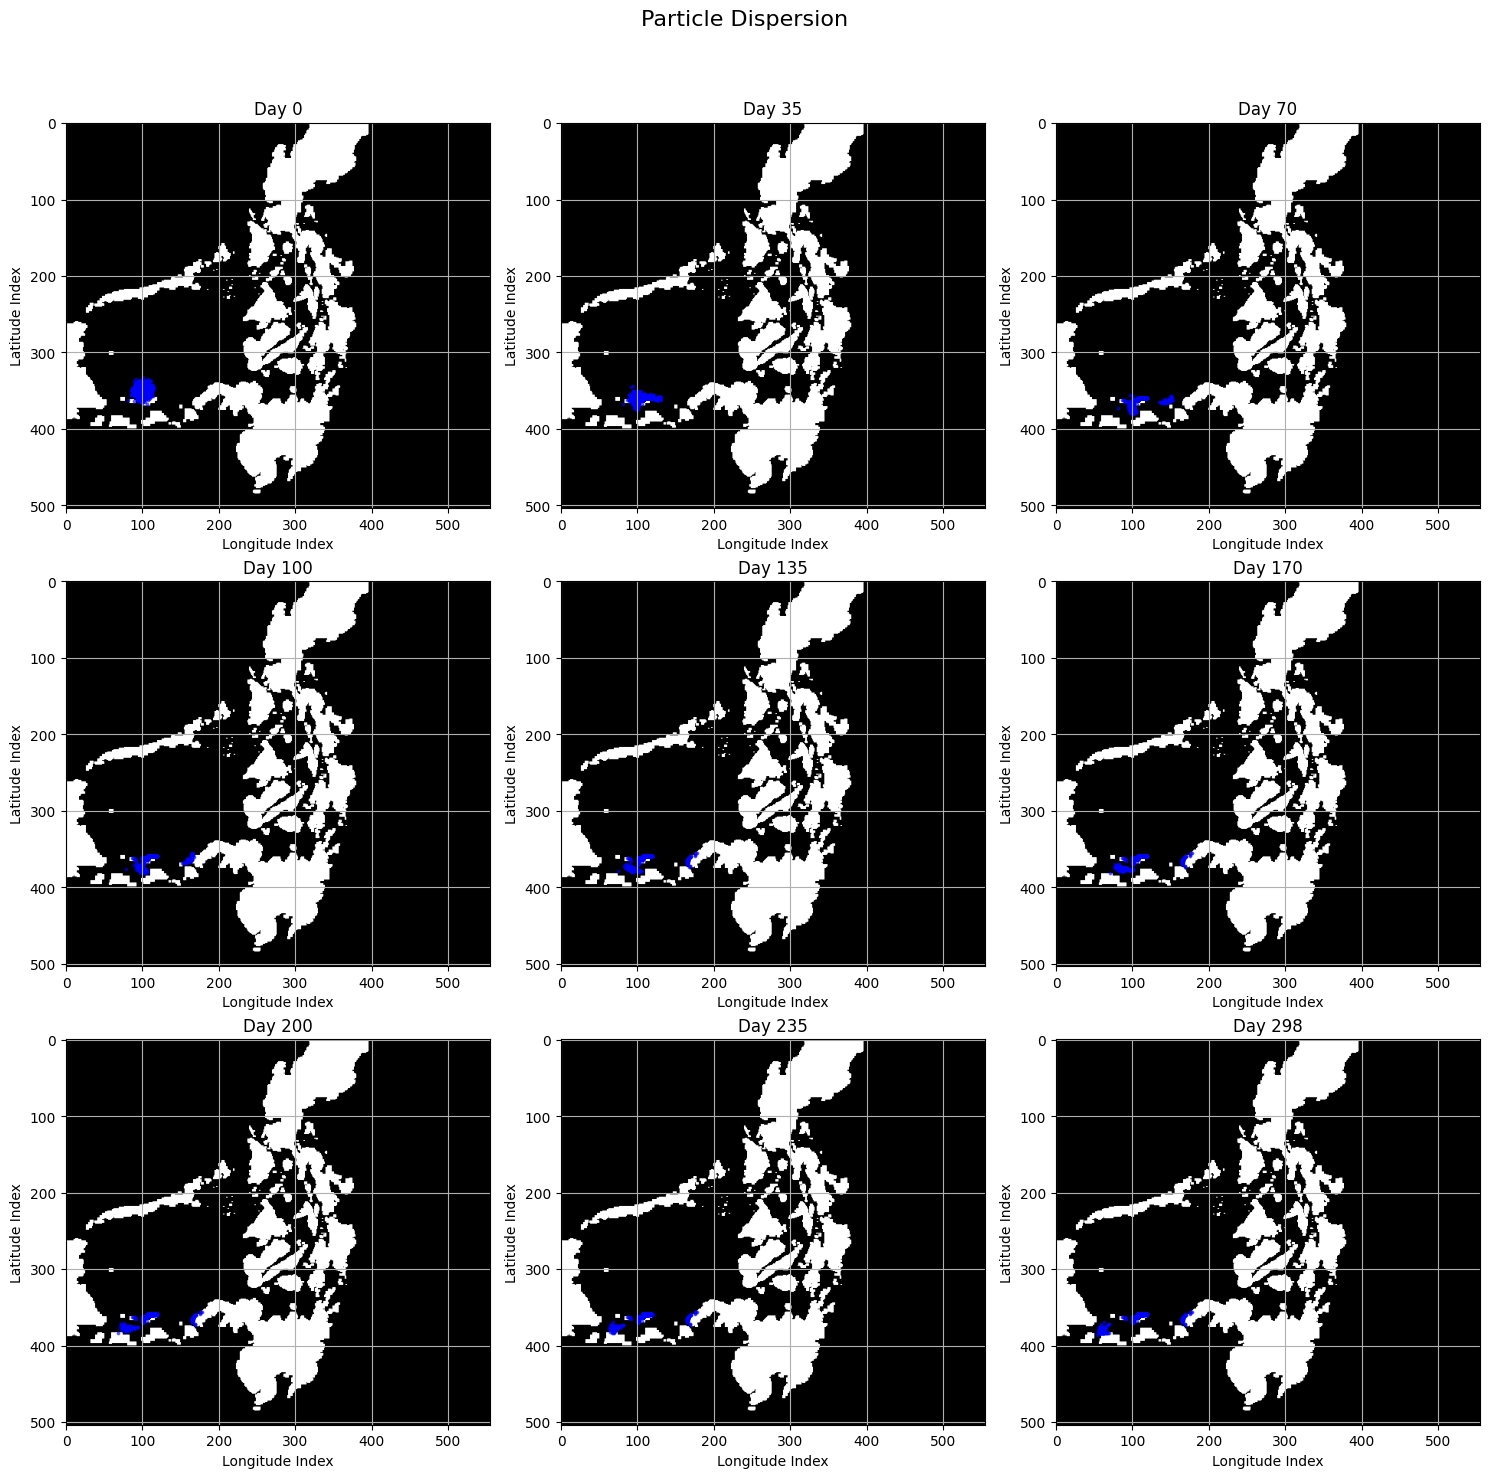

In [ ]:

def plot_particles_grid(pos_list, mask, days, title="Particle Dispersion"):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle(title, fontsize=16)

    for idx, day in enumerate(days):
        ax = axes[idx // 3, idx % 3]
        ax.imshow(mask, cmap='Greys', origin='upper')
        ax.scatter(pos_list[day][:, 0], pos_list[day][:, 1], s=3, alpha=0.5, c='blue')
        ax.set_title(f"Day {day}")
        ax.set_xlabel("Longitude Index")
        ax.set_ylabel("Latitude Index")
        ax.grid(True)

    # Hide unused axes (if any)
    for i in range(len(days), 9):
        fig.delaxes(axes[i // 3, i % 3])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Pick 9 representative days (e.g., every ~35 days)
days_to_plot = [0, 35, 70, 100, 135, 170, 200, 235, 298]
plot_particles_grid(positions_list, mask, days_to_plot)



**Figure** shows the simulation snapshots for **σ = 25**:

- **Blue particles**: Still in the ocean  
- **Red particles**: Reached land  
- **Cross and dot (final panel)**: Suggested land and water search locations, respectively  

**Suggested Search Locations (σ = 25):**

- **On land**: [106.489, 361.661] – *Pangutaran*, due to a dense cluster of terminating particles  
- **In ocean**: [54.683, 383.4333] – *Near Languyan in Tawi Tawi islands*, due to persistent floating debris

---


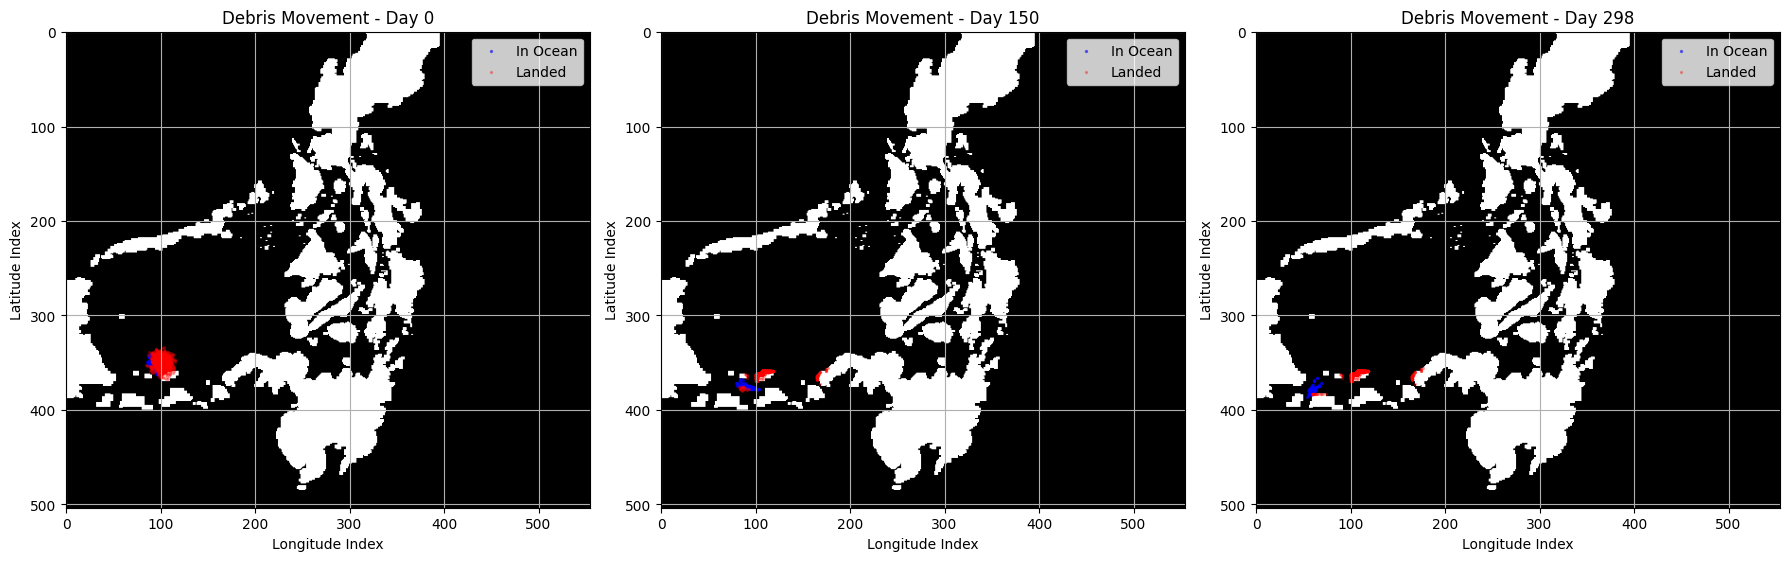

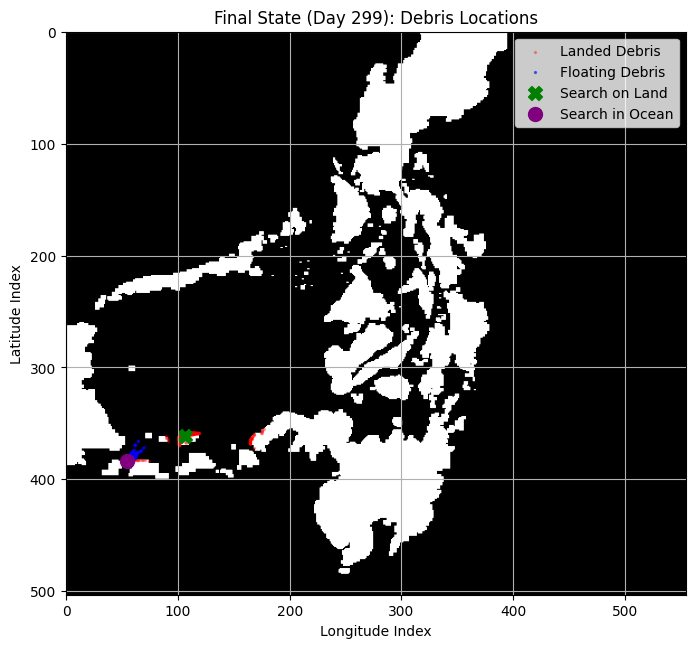

Suggested search locations:
On land: [106.48005367 361.6611224 ] — because many particles clustered and terminated here.
In ocean: [ 54.68318604 383.43337394] — persistent floating particles suggest debris concentration.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Setup
num_particles = 2000
mean = [100, 350]
cov = [[25, 0], [0, 25]]

positions = np.random.multivariate_normal(mean, cov, num_particles)
positions = np.clip(positions, [0, 0], [u_stack.shape[1] - 1, u_stack.shape[2] - 1])

positions_list = [positions.copy()]
landed = np.zeros(num_particles, dtype=bool)

# Simulate for 300 days
for t in range(298):
    new_positions = positions.copy()

    for i, pos in enumerate(positions):
        y, x = int(pos[1]), int(pos[0])

        if mask[y, x] == 0:
            landed[i] = True
            continue

        if landed[i]:
            continue

        u = u_stack_interp[t, y, x]
        v = v_stack_interp[t, y, x]

        new_x = pos[0] + u
        new_y = pos[1] + v

        new_x = np.clip(new_x, 0, u_stack.shape[2] - 1)
        new_y = np.clip(new_y, 0, u_stack.shape[1] - 1)

        if mask[int(new_y), int(new_x)] == 0:
            landed[i] = True
        else:
            new_positions[i] = [new_x, new_y]

    positions = new_positions
    positions_list.append(positions.copy())

# Helper function to plot
def plot_particles_progress(pos_list, mask, days, landed, title):
    fig, axes = plt.subplots(1, len(days), figsize=(6 * len(days), 6))
    if len(days) == 1:
        axes = [axes]

    for ax, day in zip(axes, days):
        ax.imshow(mask, cmap='Greys', origin='upper')

        pos_day = pos_list[day]
        active = np.where(~landed)[0]
        hit_land = np.where(landed)[0]

        ax.scatter(pos_day[active, 0], pos_day[active, 1], s=2, c='blue', alpha=0.5, label='In Ocean')
        ax.scatter(pos_day[hit_land, 0], pos_day[hit_land, 1], s=2, c='red', alpha=0.3, label='Landed')

        ax.set_title(f"{title} - Day {day}")
        ax.set_xlabel("Longitude Index")
        ax.set_ylabel("Latitude Index")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

# Plotting
plot_particles_progress(positions_list, mask, days=[0, 150, 298], landed=landed, title="Debris Movement")

# Mark final landing locations
final_positions = positions_list[-1]
landed_positions = final_positions[landed]
floating_positions = final_positions[~landed]

# Pick one on land and one in ocean for marking
debris_on_land = landed_positions[np.random.choice(len(landed_positions))]
debris_in_ocean = floating_positions[np.random.choice(len(floating_positions))]

# Mark those explicitly
plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap='Greys', origin='upper')
plt.scatter(landed_positions[:, 0], landed_positions[:, 1], s=2, c='red', alpha=0.3, label='Landed Debris')
plt.scatter(floating_positions[:, 0], floating_positions[:, 1], s=2, c='blue', alpha=0.5, label='Floating Debris')

plt.scatter(*debris_on_land, c='green', s=100, marker='X', label='Search on Land')
plt.scatter(*debris_in_ocean, c='purple', s=100, marker='o', label='Search in Ocean')

plt.title("Final State (Day 299): Debris Locations")
plt.xlabel("Longitude Index")
plt.ylabel("Latitude Index")
plt.legend()
plt.grid(True)
plt.show()

print("Suggested search locations:")
print(f"On land: {debris_on_land} — because many particles clustered and terminated here.")
print(f"In ocean: {debris_in_ocean} — persistent floating particles suggest debris concentration.")



**Figure** shows the simulation snapshots for **σ = 100**:

**Suggested Search Locations (σ = 100):**

- **On land**: [101.7045, 361.801] – *Pangutaran, Hadji Muhtamad, Zamboanga*, due to landfall clusters  
- **In ocean**: [99.1407, 342.0767] – *North of Pangutaran islands*, consistent with marine particle convergence

---




**Interpretation:**

As **initial uncertainty increases**, the **search swath expands**. While some particles reach distant coasts in the northern **Philippines**, **most debris tends to accumulate along the concave shores** of nearby islands, reinforcing their plausibility as target search zones.

This simulation demonstrates the importance of long-term modeling in guiding effective and efficient **debris search and rescue operations**.

### ** Identifying Candidate Search Stations**

To systematically identify optimal **search station locations**, we initialized **10,000 particles uniformly at random** across the **entire ocean map**, **excluding particles starting on land** to prevent skewed results due to terrain constraints.

Each particle was **advected daily** using the previously estimated **velocity fields** (from GP interpolation). Their **trajectories were tracked** over the entire 300-day simulation.

Upon analyzing the **final positions** of particles that reached the **shoreline**, we identified **eight coastal regions** with the **highest density of landfall events**. These locations were chosen as **candidate search station sites**.

These regions are:

- High-density particle accumulation zones
- Strategically positioned along coastlines due to flow and geographic concavity
- Proximate to major **port cities**, **highways**, and **logistics infrastructure**

Such regions offer **rapid deployment capability**, **accessibility**, and **logistical advantages** for **search and rescue missions** or **ocean monitoring**.

---

**Visual Aids:**

- **Fig.**: Simulation of 10,000 uniformly distributed particles over the ocean.  
  - **Red**: Particles that reached the coast at each timestamp  



Positions initialized
Simulation complete


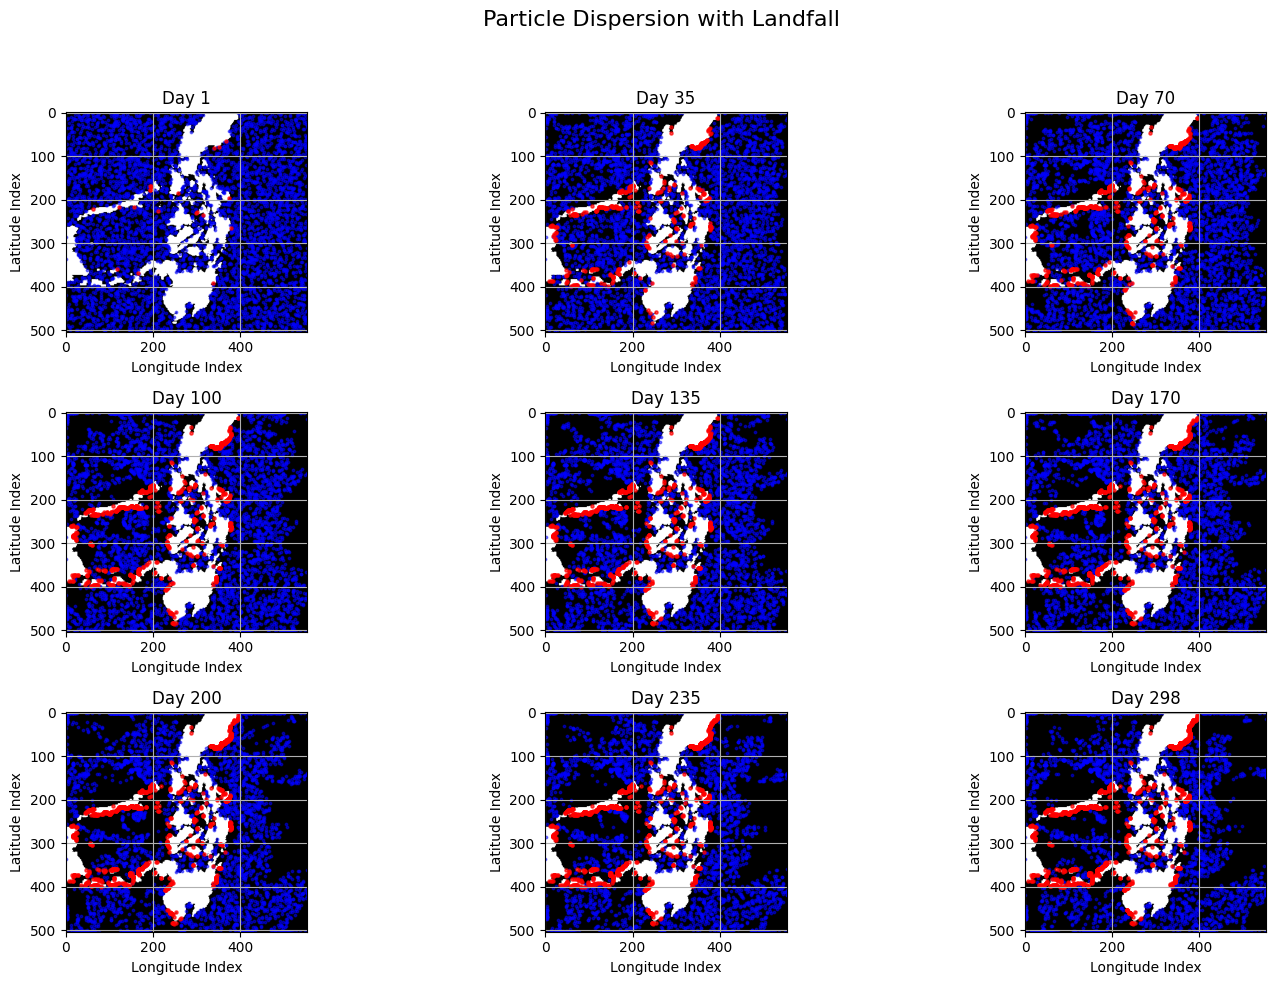

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Settings ---
num_particles = 5000
num_days = 298

# --- Initialize particles uniformly over ocean ---
positions = []
while len(positions) < num_particles:
    x = np.random.uniform(0, u_stack.shape[2] - 1)
    y = np.random.uniform(0, u_stack.shape[1] - 1)
    if mask[int(y), int(x)] == 1:  # Only ocean
        positions.append([x, y])

positions = np.array(positions)
landed = np.zeros(num_particles, dtype=bool)

positions_list = [positions.copy()]
landed_list = [landed.copy()]

print('Positions initialized')

# --- Particle Advection ---
for t in range(num_days):
    new_positions = positions.copy()
    new_landed = landed.copy()

    for i, pos in enumerate(positions):
        if landed[i]:
            continue  # Skip landed particles

        y, x = int(pos[1]), int(pos[0])  # (row, col)

        u = u_stack_interp[t, y, x]
        v = v_stack_interp[t, y, x]

        new_x = pos[0] + u
        new_y = pos[1] + v

        # Stay within domain
        new_x = np.clip(new_x, 0, u_stack.shape[2] - 1)
        new_y = np.clip(new_y, 0, u_stack.shape[1] - 1)

        # Check if landed
        if mask[int(new_y), int(new_x)] == 0:
            new_landed[i] = True

        if not new_landed[i]:
            new_positions[i] = [new_x, new_y]

    positions = new_positions
    landed = new_landed

    positions_list.append(positions.copy())
    landed_list.append(landed.copy())

print('Simulation complete')

# --- Plotting Function ---
def plot_particles_grid(pos_list, landed_list, mask, days, title="Particle Dispersion with Landfall"):
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    fig.suptitle(title, fontsize=16)

    for idx, day in enumerate(days):
        ax = axes[idx // 3, idx % 3]
        ax.imshow(mask, cmap='Greys', origin='upper')

        pos = pos_list[day]
        landed = landed_list[day]

        ax.scatter(pos[~landed, 0], pos[~landed, 1], s=3, color='blue', alpha=0.5)
        ax.scatter(pos[landed, 0], pos[landed, 1], s=5, color='red', alpha=0.7)

        ax.set_title(f"Day {day}")
        ax.set_xlabel("Longitude Index")
        ax.set_ylabel("Latitude Index")
        ax.grid(True)

    # Hide unused axes (if any)
    for i in range(len(days), 9):
        fig.delaxes(axes[i // 3, i % 3])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- Plot ---
days_to_plot = [1, 35, 70, 100, 135, 170, 200, 235, 298]
plot_particles_grid(positions_list, landed_list, mask, days_to_plot)


- **Marked candidates for search station deployment**, overlaid on the final snapshot

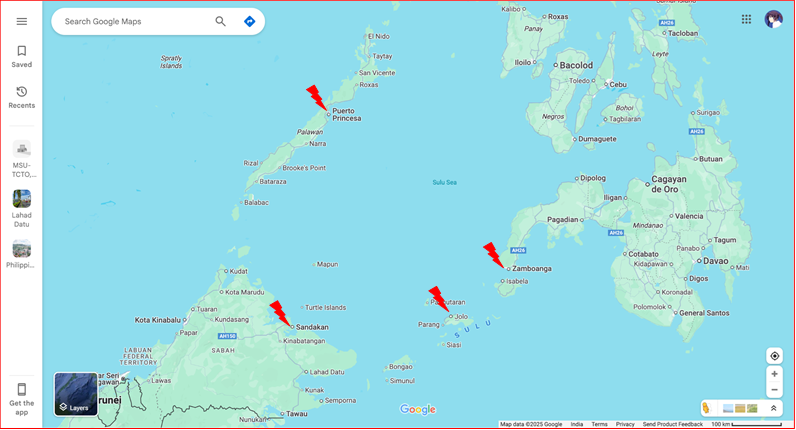
---

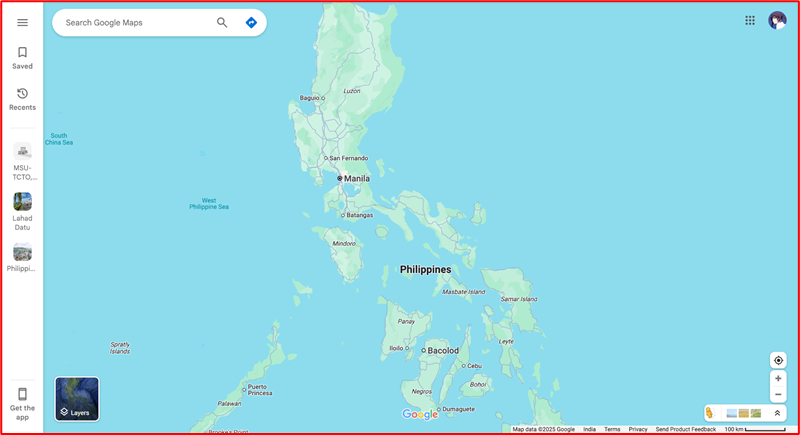

**Conclusion:**

This methodology enables **data-driven selection** of search station locations by leveraging **long-term ocean flow modeling** and **coastal impact analysis**. These stations can be used not only in **search and rescue contexts**, but also for **debris tracking**, **pollution monitoring**, and **coastal preparedness planning**.